In [1]:
import os
import re
import math
import typing
import warnings
from enum import Enum

import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib as mpl
from scipy.stats import zscore
import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split

from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important}; </style>"))

In [2]:
warnings.filterwarnings(
    action='ignore',
    message='înternal gelsd'
)

warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning
)

In [3]:
np.random.seed(1)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
# Matplotlib set label size
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

In [5]:
sns.set_style('whitegrid')
sns.set_context(
    'notebook',
    font_scale=1,
    rc={
        'lines.linewidth': 2,
        'font.family': [u'times']
    }
)

## Data Loading

We have multiple houses, and we want to predict their **market price**.
So we are going to explore the features that we have.

In [6]:
train_set = pd.read_csv('./data/train_set.csv', index_col=0)
test_set = pd.read_csv('./data/test_set.csv', index_col=0)

### Train/Val Split

We are going to make the train/validation split before we start the exploration of the dataset, this way we make sure we are not biased.

<AxesSubplot:>

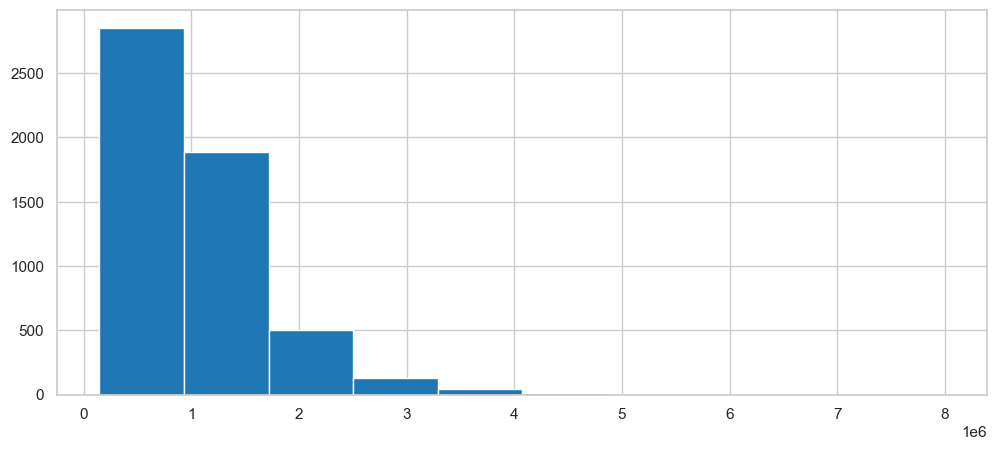

In [7]:
train_set.Price.hist()

In [8]:
train_set['price_range'] = pd.cut(train_set.Price, bins=[.0, .5e6, 1e6, 1.5e6, 2e6, 10e6], labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

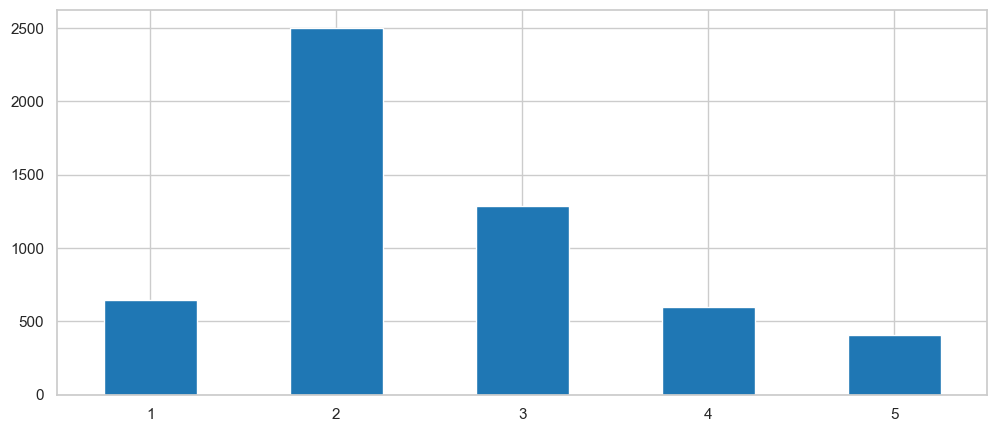

In [9]:
train_set.price_range.value_counts().sort_index().plot.bar(rot=0, grid=True)

In [10]:
train_set_labels = train_set.drop(['price_range'], axis=1, inplace=False)
train_set_target = train_set.price_range

X_train, X_val, Y_train, Y_val = train_test_split(
    train_set_labels, 
    train_set_target, 
    stratify=train_set_target, 
    test_size=.1,
    random_state=0
)

In [11]:
train_set = pd.concat([X_train, Y_train], axis=1).drop(['price_range'], axis=1)
valid_set = pd.concat([X_val, Y_val], axis=1).drop(['price_range'], axis=1)

In [12]:
print('Size of train set: ', train_set.shape[0])
print('Size of validation set: ', valid_set.shape[0])
print('Size of test set: ', test_set.shape[0])

Size of train set:  4888
Size of validation set:  544
Size of test set:  8148


In [13]:
train_set.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
index,,,,,,,,,,,,,,,,,,,,,
3320,Bundoora,50 Cameron Pde,3,h,687000.0,S,Ray,17/06/2017,12.1,3083.0,3.0,1.0,3.0,559.0,NaN,NaN,Banyule,-37.69849,145.06705,Northern Metropolitan,10175.0
1185,Kensington,25 Rogan La,2,t,700000.0,S,Village,19/11/2016,4.2,3031.0,2.0,1.0,3.0,62.0,NaN,1997.0,Melbourne,-37.79170,144.92310,Northern Metropolitan,5263.0
5059,Essendon,27 Miller St,3,h,1320000.0,S,Rendina,3/06/2017,7.5,3040.0,3.0,2.0,1.0,276.0,149.0,1910.0,Moonee Valley,-37.75126,144.89558,Western Metropolitan,9264.0


## Data Exploration

In [14]:
def diplay_unique_values(df: pd.DataFrame):
    for column in train_set.columns.values:
        print(f'{column.capitalize()} - {train_set[column].dtype} - ', train_set[column].nunique())
    
diplay_unique_values(train_set)

Suburb - object -  290
Address - object -  4861
Rooms - int64 -  8
Type - object -  3
Price - float64 -  1364
Method - object -  5
Sellerg - object -  195
Date - object -  58
Distance - float64 -  192
Postcode - float64 -  185
Bedroom2 - float64 -  11
Bathroom - float64 -  9
Car - float64 -  10
Landsize - float64 -  1099
Buildingarea - float64 -  421
Yearbuilt - float64 -  115
Councilarea - object -  32
Lattitude - float64 -  3299
Longtitude - float64 -  3513
Regionname - object -  8
Propertycount - float64 -  287


In [15]:
train_set.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,4888.000000,4.888000e+03,4888.000000,4888.000000,4888.000000,4888.000000,4866.000000,4888.000000,2587.000000,2962.000000,4888.000000,4888.000000,4888.000000
mean,2.938421,1.077072e+06,10.248159,3106.002455,2.918576,1.534984,1.629470,534.433715,166.065247,1965.187036,-37.810062,144.994992,7398.589812
std,0.952790,6.424295e+05,6.022727,94.718199,0.991636,0.702245,0.988207,1573.360422,890.695946,36.224880,0.079412,0.107535,4350.388614
min,1.000000,1.450000e+05,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1830.000000,-38.174880,144.542370,389.000000
25%,2.000000,6.500000e+05,6.200000,3044.000000,2.000000,1.000000,1.000000,184.000000,92.000000,1940.000000,-37.856865,144.928408,4242.000000
50%,3.000000,9.000000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,450.000000,125.000000,1970.000000,-37.803500,144.999670,6543.000000
75%,3.000000,1.330250e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,655.000000,175.000000,1999.000000,-37.757400,145.059647,10331.000000
max,8.000000,8.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,75100.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


We can see there are no strange negative values.

In [16]:
# We can assess how many nulls we have from each column
nan_cols = train_set.columns[train_set.isna().any()].tolist()

for nan_col in nan_cols:
    print(f'Column {nan_col}:', train_set[nan_col].isna().sum())

Column Car: 22
Column BuildingArea: 2301
Column YearBuilt: 1926
Column CouncilArea: 503


We can now see that we have also a bit of nullity relation between `Propertycount`, `Car`, and then with `CouncilArea`.

### Categorical Variables

In [17]:
# Can take a closer look to the object ones
train_set.select_dtypes(include=['object']).head(3)

,Suburb,Address,Type,Method,SellerG,Date,CouncilArea,Regionname
index,,,,,,,,
3320,Bundoora,50 Cameron Pde,h,S,Ray,17/06/2017,Banyule,Northern Metropolitan
1185,Kensington,25 Rogan La,t,S,Village,19/11/2016,Melbourne,Northern Metropolitan
5059,Essendon,27 Miller St,h,S,Rendina,3/06/2017,Moonee Valley,Western Metropolitan


### Type

<AxesSubplot:xlabel='count', ylabel='Type'>

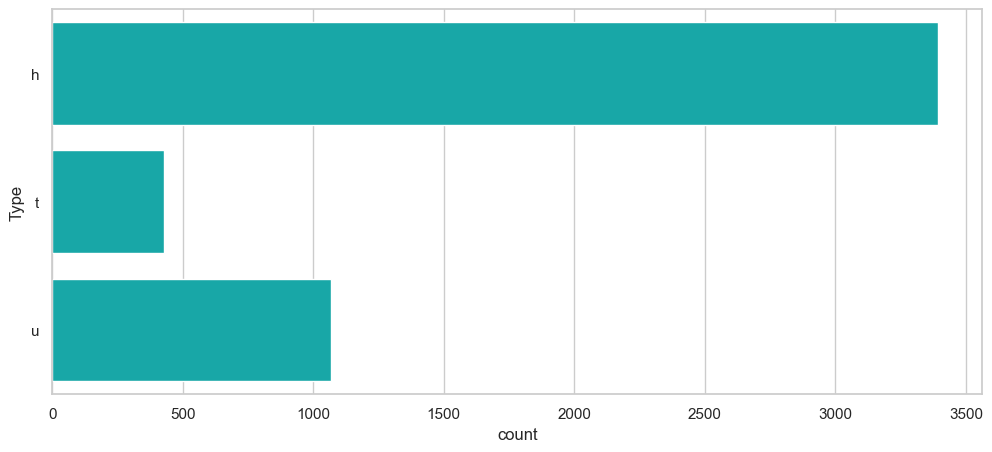

In [18]:
sns.countplot(
    y='Type',
    data=train_set,
    color='c'
)

We have the different types:
- **h**: hourse, cottage, villa, semi, terrace
- **u**: unit, duplex
- **t**: townhouse

And we can see that the majority of them are of type *h*.

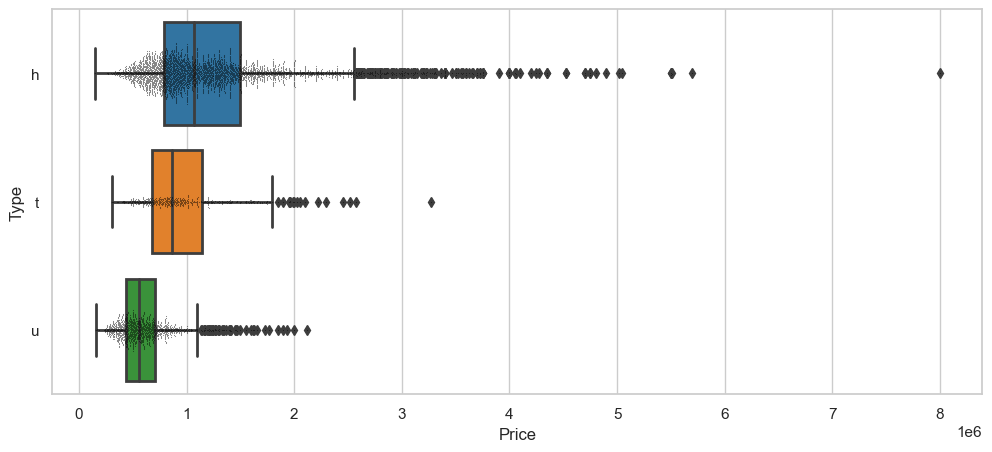

In [19]:
sns.boxplot(
    x='Price',
    y='Type',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Type", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

We can see important outliers.

Will create a function that removes the outliers grouping by certain categorical variables.

In [20]:
# We will compute the z-score for the prices of houses grouping by the region, and removing outliers (z-score > 3)
def rm_categorical_target_col_outlier(
    df: pd.DataFrame,
    target_col: str = 'Price',
    group_cols: typing.List[str] = ['Type', 'Method', 'Regionname'],
    bound: typing.Tuple[float, float] = (-3., 3.),
    drop_set: bool = set(),
    drop: bool = True
) -> typing.List[int]:
    
    all_dropped = []
    
    for group_col in group_cols:
        for group in df[group_col].unique():
            df_subset = df.loc[df[group_col] == group, target_col].to_frame()
            subset_z_score = df_subset.apply(zscore)

            # And now we drop those indices of the rows that have z-score out of bounds (-3, 3)
            to_drop = list(
                (subset_z_score[(subset_z_score > bound[1]).values].index)) + list(
                (subset_z_score[(subset_z_score < bound[0]).values].index)
            )
            all_dropped += to_drop

    # So we do not interfere in detecting other outliers
    all_dropped = set(all_dropped)
    all_dropped = all_dropped | drop_set
    
    if drop:
        df.drop(
            all_dropped, 
            axis=0, 
            inplace=True
        )
    
    return df, all_dropped

In [21]:
_, drop_set = rm_categorical_target_col_outlier(
    train_set, 
    drop=False
)

_, drop_set = rm_categorical_target_col_outlier(
    train_set, 
    target_col='Landsize', 
    bound=(-3, 2.5),
    drop_set=drop_set, 
    drop=False
)

train_set, _ = rm_categorical_target_col_outlier(
    train_set, 
    target_col='BuildingArea', 
    bound=(-3, 2.5),
    drop_set=drop_set
)

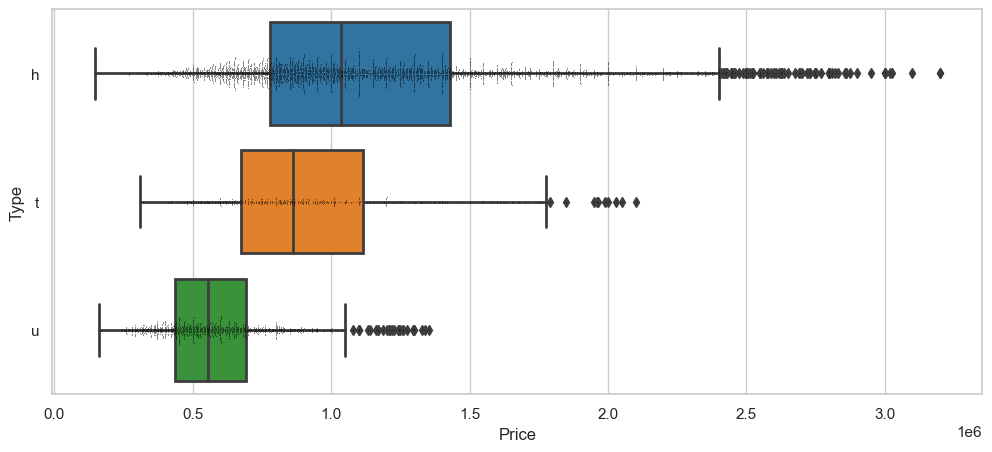

In [22]:
# And can compare with the before plot
sns.boxplot(
    x='Price',
    y='Type',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Type", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

We can make a qqplot to see if there is normality of the pricess grouping by this categorical variable.

In [23]:
def qqplot_price_category(
    df: pd.DataFrame, 
    category_group: str,
    target_col: typing.Optional[str] = 'Price',
    input_shape: typing.Optional[typing.List[int]] = [1, 3],
    delete_last: typing.Optional[bool] = False
):
    # Consider normality of price distribution in each group to apply ANOVA 
    fig, axs = plt.subplots(input_shape[0], input_shape[1], figsize=(16, 14))

    x_row, y_col = 0, -1
    for idx, value in enumerate(df[category_group].unique()):
        x_row = x_row + 1 if idx % 3 == 0 and idx > 0 else x_row
        y_col = y_col - 2 if idx % 3 == 0 and idx > 0 else y_col + 1
        
        region_set = df.loc[df[category_group].eq(value), target_col]
        
        ax = axs[x_row, y_col] if input_shape[0] > 1 else axs[idx]

        pg.qqplot(
            region_set, 
            dist='norm', 
            ax=ax
        )
        ax.set_title(value)

    plt.tight_layout()
    
    if delete_last:
        fig.delaxes(axs[input_shape[0] - 1][input_shape[1] - 1])

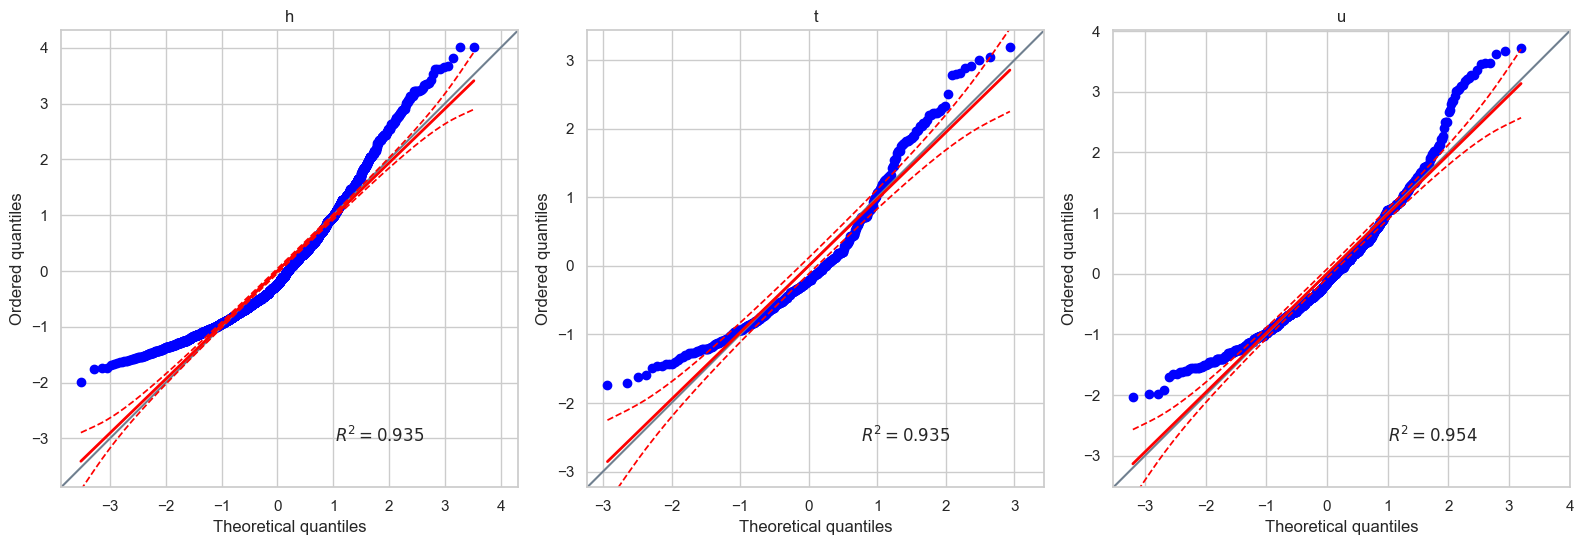

In [24]:
qqplot_price_category(
    train_set,
    category_group='Type'
)

In [25]:
# We can make Levene homoscedasticity test
pg.homoscedasticity(
    data=train_set, 
    dv='Price', 
    group='Type', 
    method='levene'
)

,W,pval,equal_var
levene,242.370964,7.192351e-101,False


### Region Name

Visualize a boxplot with the outliers also removed for this categorical variable.

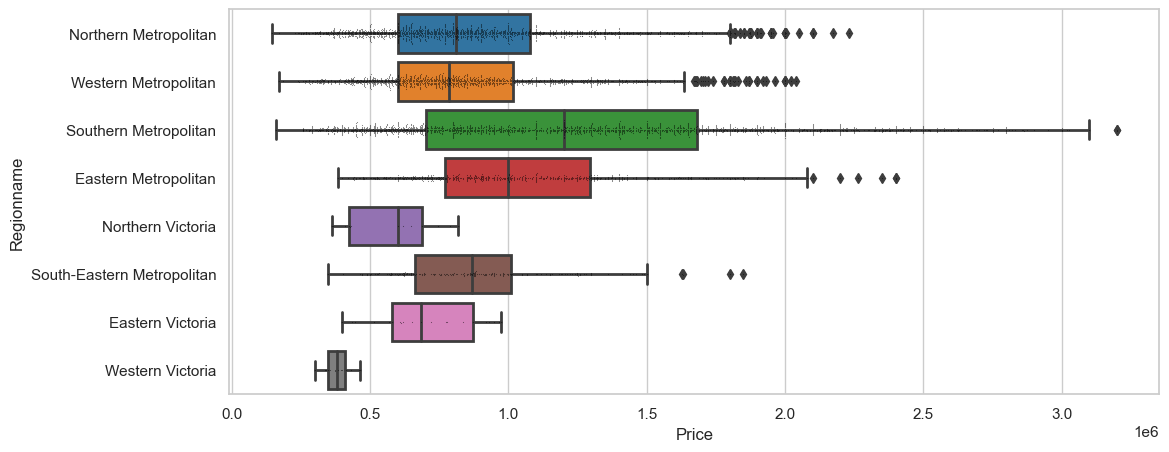

In [26]:
sns.boxplot(
    x='Price',
    y='Regionname',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Regionname", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

We can still see that there is a difference in the visualization on the distribution.

We might have to do a test to know if this difference of distributions is important to take into consideration. For this, we could make an ANOVA test.

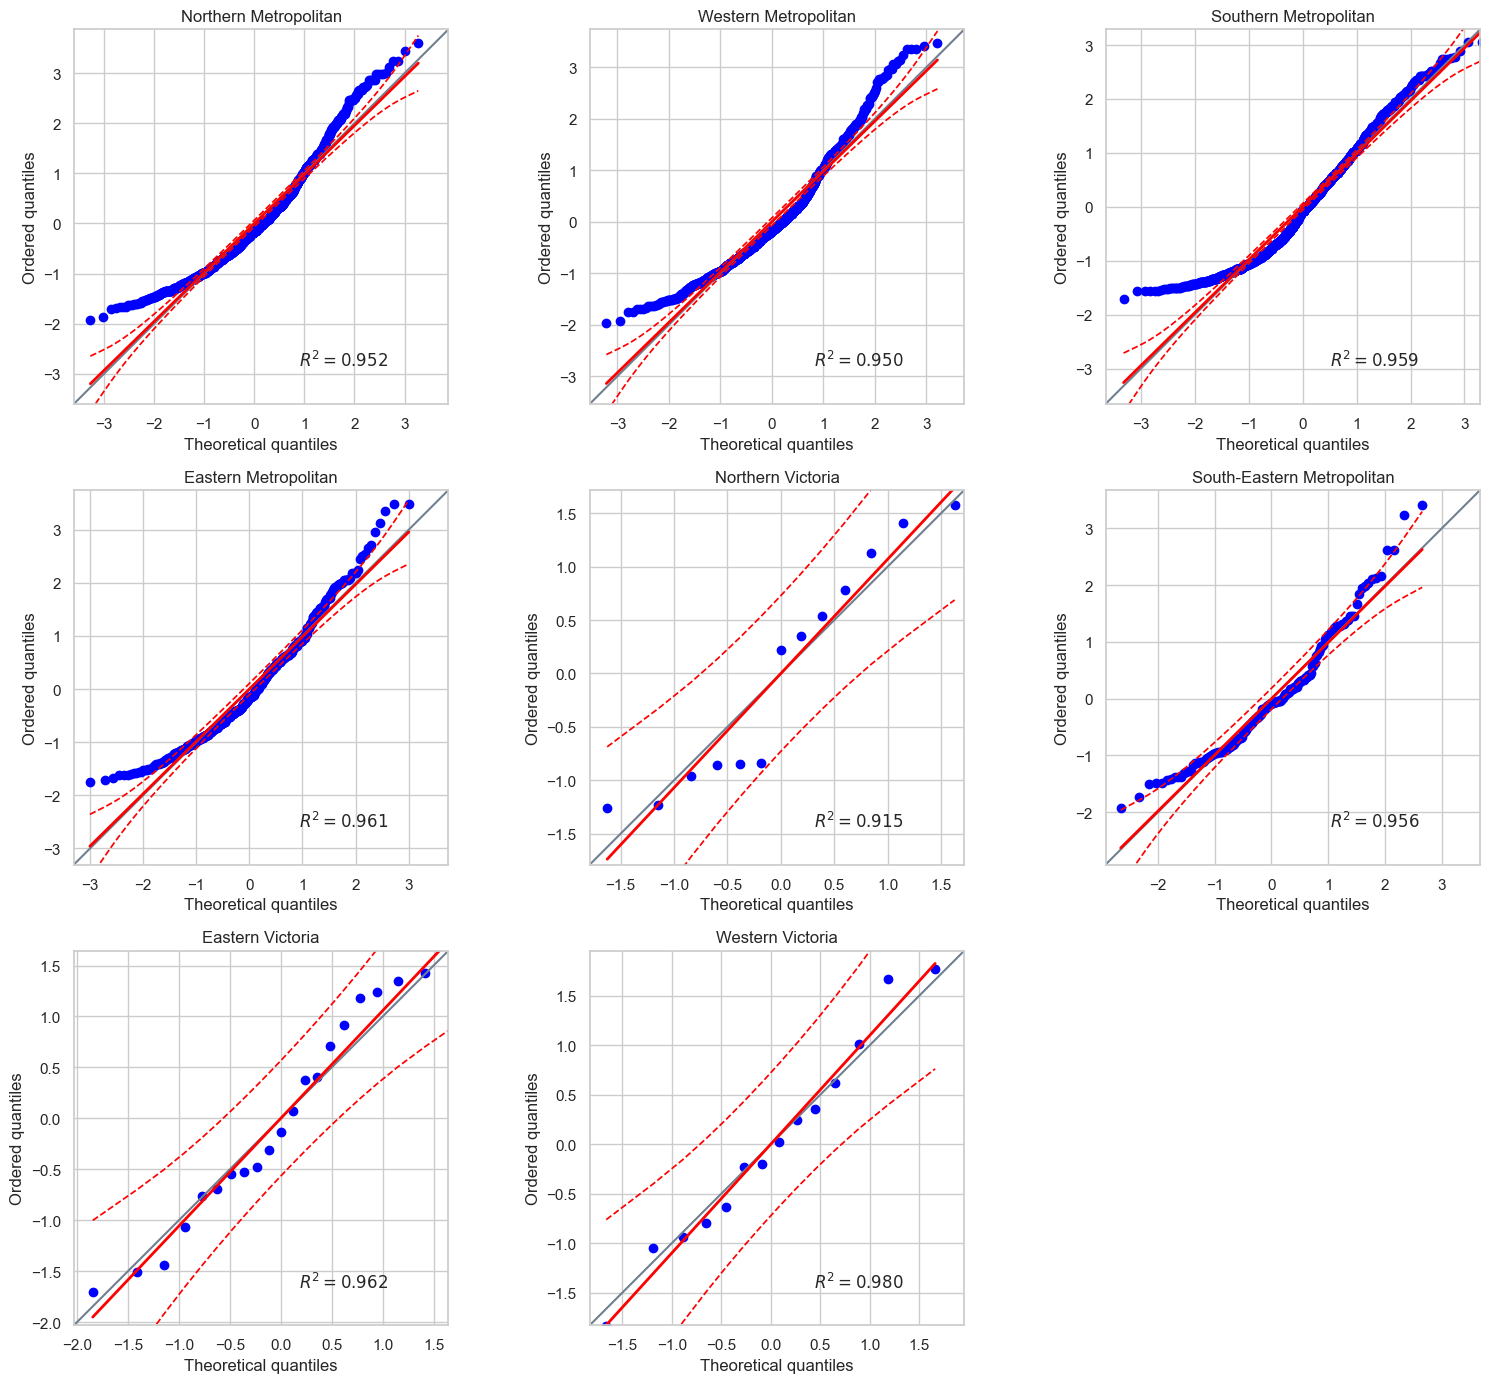

In [27]:
qqplot_price_category(
    train_set,
    category_group = 'Regionname',
    input_shape = [3, 3],
    delete_last=True
)

In [28]:
# We can also make the test Shapiro-Wilk to assess the normality
pg.normality(
    data=train_set, 
    dv='Price', 
    group='Regionname'
)

,W,pval,normal
Regionname,,,
Northern Metropolitan,0.951057,1.635049e-20,False
Western Metropolitan,0.949255,1.191204e-18,False
Southern Metropolitan,0.958641,1.344435e-20,False
Eastern Metropolitan,0.960411,1.479844e-10,False
Northern Victoria,0.888075,9.182026e-02,True
South-Eastern Metropolitan,0.955730,2.569383e-05,False
Eastern Victoria,0.941450,2.327526e-01,True
Western Victoria,0.974835,9.337593e-01,True


In [29]:
# We can make Levene homoscedasticity test
pg.homoscedasticity(
    data=train_set, 
    dv='Price', 
    group='Regionname', 
    method='levene'
)

,W,pval,equal_var
levene,122.557526,7.673634e-166,False


So we can only say at most that we have **normal distributions** for two of the regions: Eastern & Western Victoria.

We can try to create the logarithm of the price, and try to assess again the normality of the distribution.

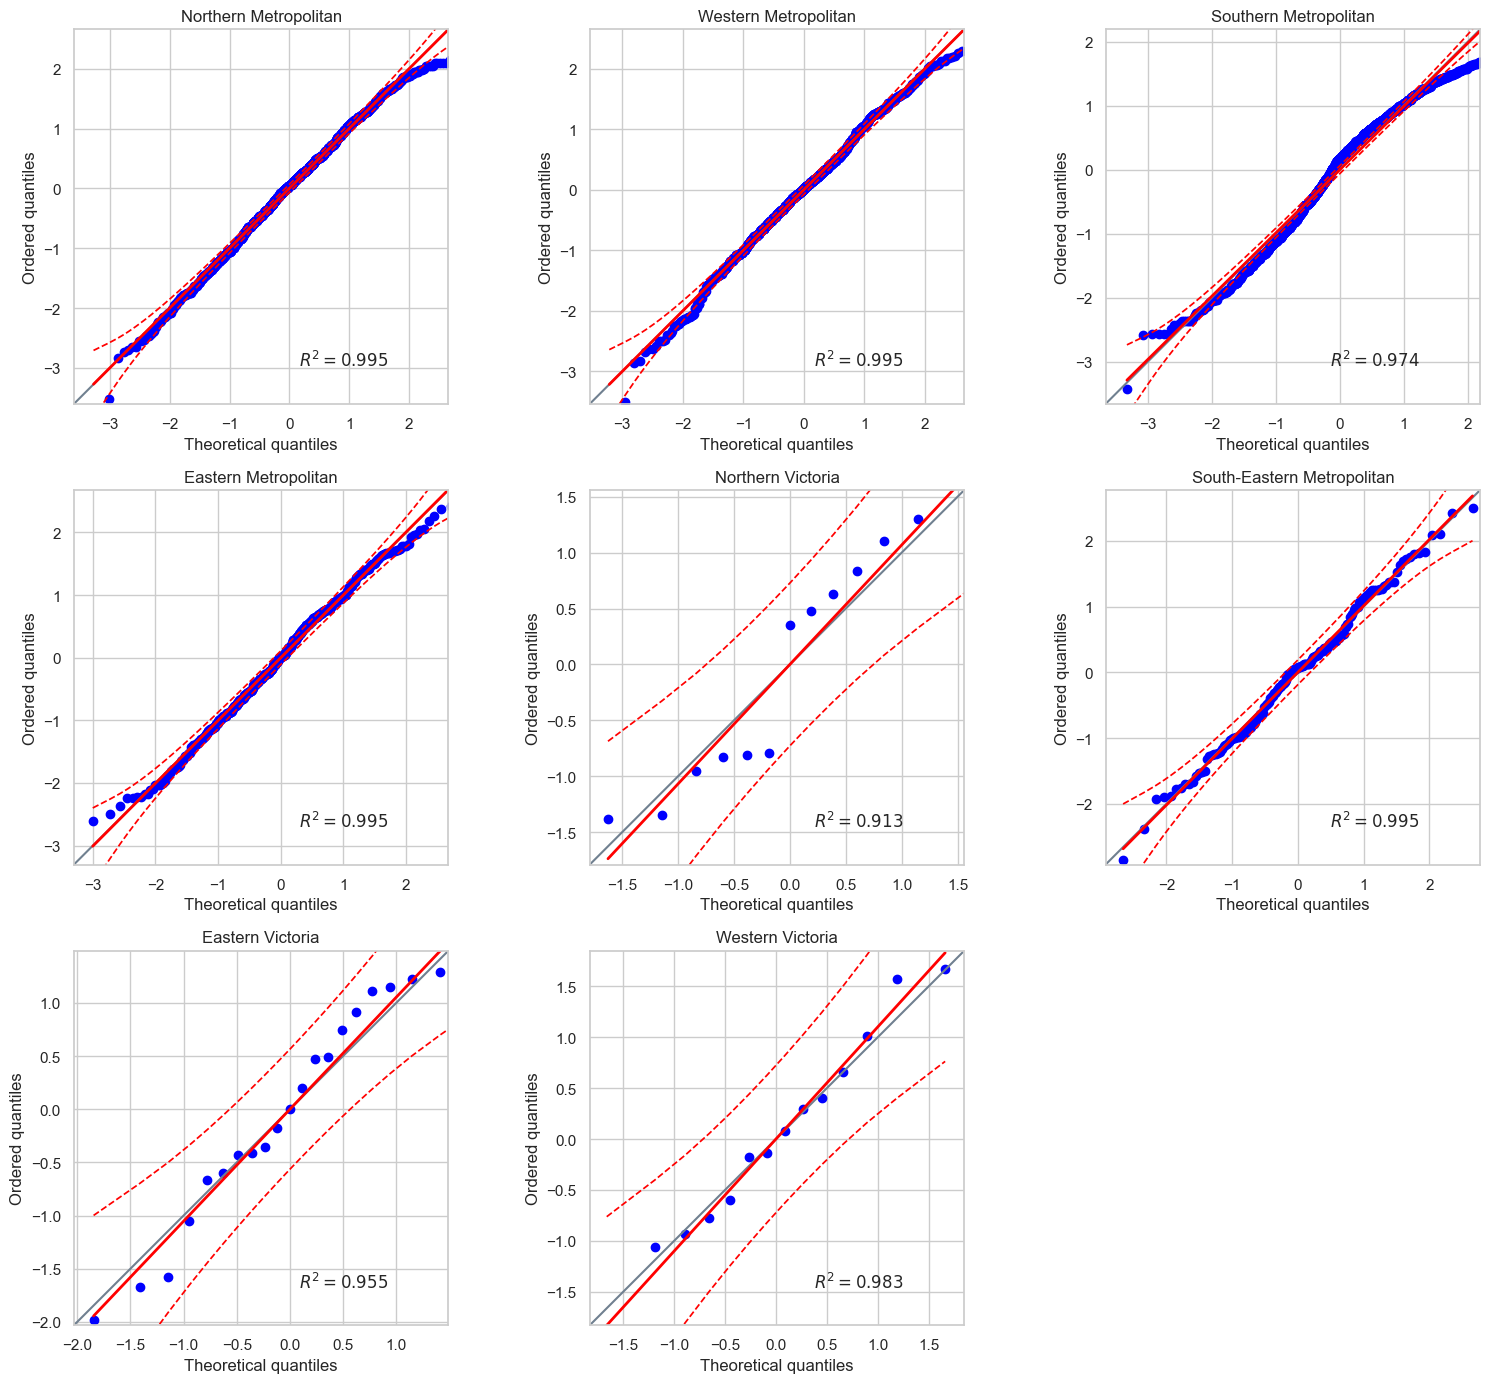

In [30]:
train_set['Price_log'] = np.log(train_set.Price)

qqplot_price_category(
    train_set, 
    target_col='Price_log',
    category_group = 'Regionname',
    input_shape = [3, 3],
    delete_last=True
)

In [31]:
pg.normality(
    data=train_set, 
    dv='Price_log', 
    group='Regionname'
)

,W,pval,normal
Regionname,,,
Northern Metropolitan,0.994590,1.095314e-04,False
Western Metropolitan,0.994749,9.465627e-04,False
Southern Metropolitan,0.973125,1.906473e-16,False
Eastern Metropolitan,0.993864,3.492184e-02,False
Northern Victoria,0.885219,8.394790e-02,True
South-Eastern Metropolitan,0.993931,6.885457e-01,True
Eastern Victoria,0.938173,2.004700e-01,True
Western Victoria,0.979431,9.713764e-01,True


It is now more like a normal distribution of the prices divided by the regions.

So we can make now an ANOVA, to assess which is the influence of the Region Name on the logarithm of the pricing.

In [32]:
pg.anova(
    data=train_set, 
    dv='Price_log', 
    between='Regionname', 
    detailed=True
)

,Source,SS,DF,MS,F,p-unc,np2
0,Regionname,117.798152,7,16.828307,78.021282,2.037610e-107,0.104905
1,Within,1005.109255,4660,0.215689,NaN,NaN,NaN


We have very small **p-value**, which means that we could reject the null hyphotesis that the means of the logarithmic prices across Region Names are the same.

### Method

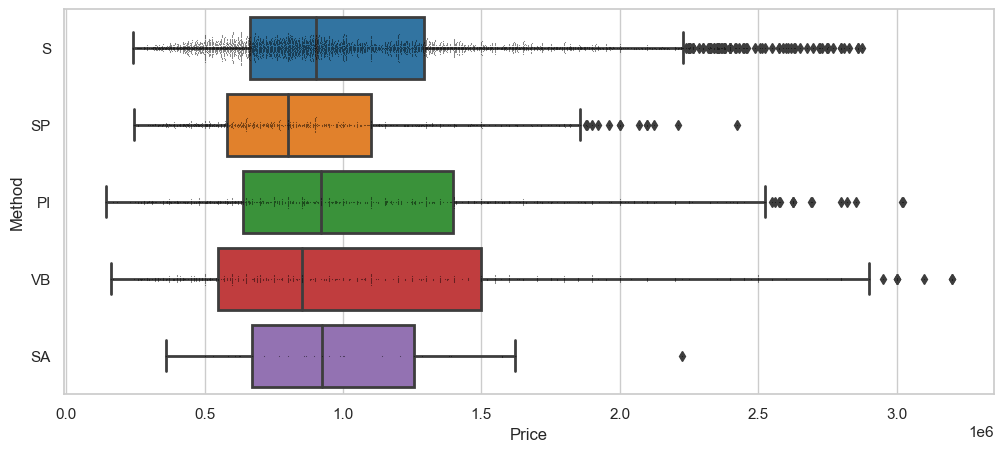

In [33]:
sns.boxplot(
    x='Price',
    y='Method',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Method", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

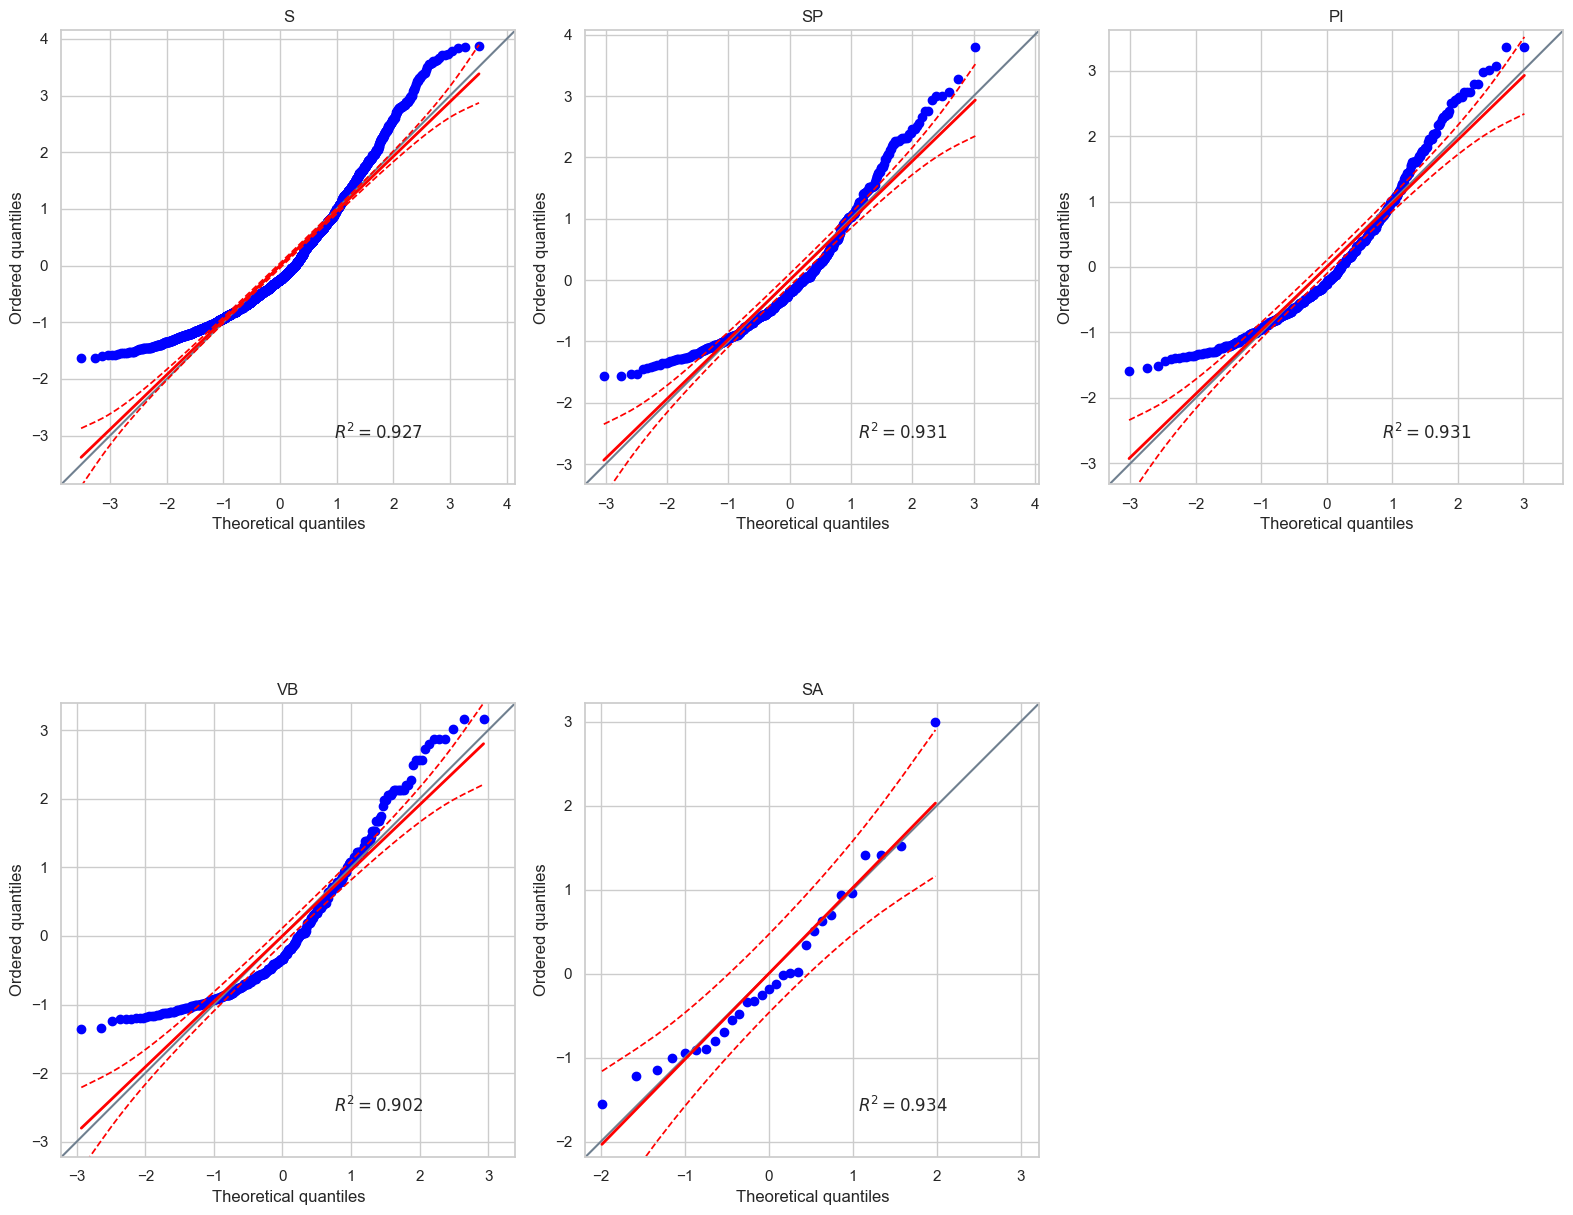

In [34]:
qqplot_price_category(
    train_set,
    category_group = 'Method',
    input_shape = [2, 3],
    delete_last=True
)

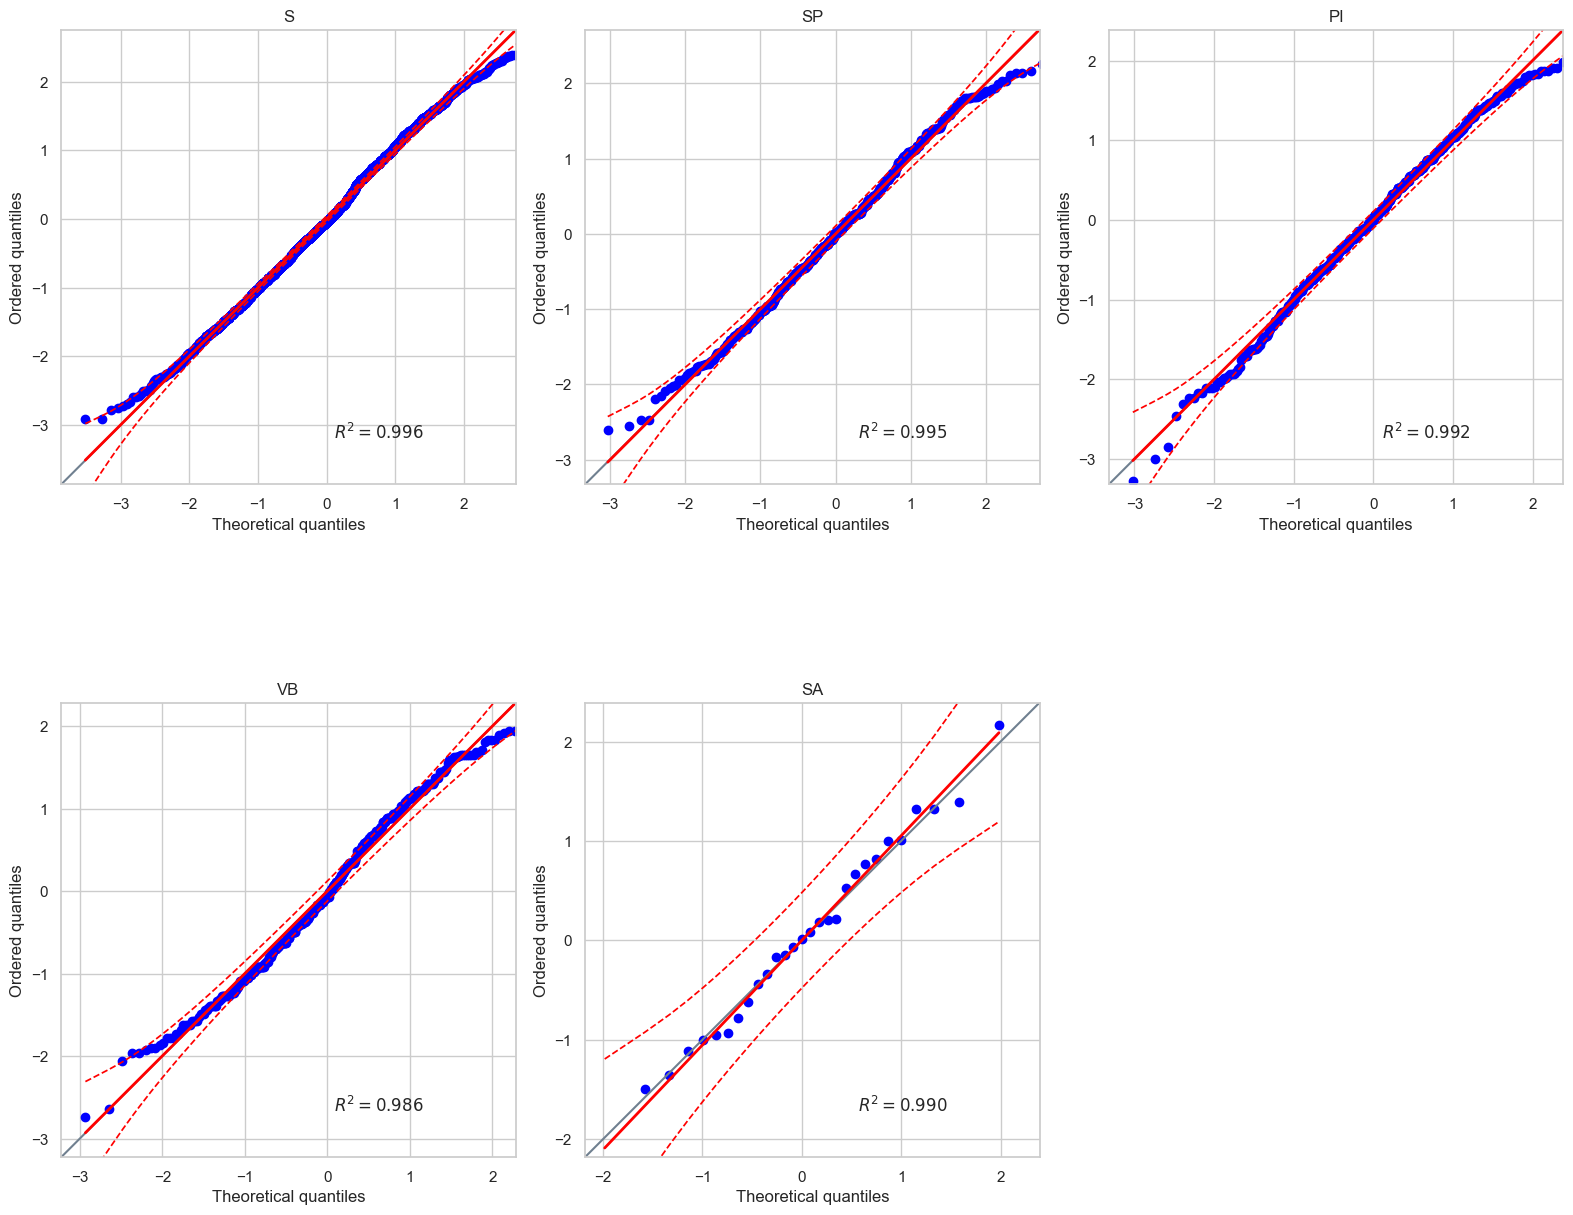

In [35]:
qqplot_price_category(
    train_set,
    target_col='Price_log',
    category_group = 'Method',
    input_shape = [2, 3],
    delete_last=True
)

In [36]:
pg.anova(
    data=train_set, 
    dv='Price', 
    between='Method', 
    detailed=True
)

,Source,SS,DF,MS,F,p-unc,np2
0,Method,1.302872e+13,4,3.257181e+12,12.853477,2.083305e-10,0.010906
1,Within,1.181644e+15,4663,2.534086e+11,NaN,NaN,NaN


## SellerG

We could try to divide the seller into normal/expensive/premium ones, depending on which is the mean of the houses that they sell.

Identifying those thresholds will be useful for feature engineering.

In [37]:
def plot_distribution_grouped_field(
    field: str, 
    expensive_divisor: int = 1.5e6, 
    premium_divisor: int = 2e6,
    font_size: int = 6
):
    
    grouped_pricing = train_set\
        .groupby(field)\
        .mean()['Price']\
        .sort_values()
    
    grouped_names = grouped_pricing.index.values.tolist()

    fig, ax = plt.subplots(figsize=(20, 10))

    sns.scatterplot(
        x=grouped_names,
        y=grouped_pricing,
        ax=ax
    )

    plt.axhline(
        y=expensive_divisor, 
        color='green',
        linestyle='--',
        label='Expensive divisor'
    )

    plt.axhline(
        y=premium_divisor, 
        color='orange',
        linestyle='dotted',
        label='Premium divisor'
    )

    plt.xticks(
        size=font_size,
        rotation=90
    );

    plt.legend()
    
    return grouped_pricing, grouped_names

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_49895/2525210817.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_pricing = train_set\


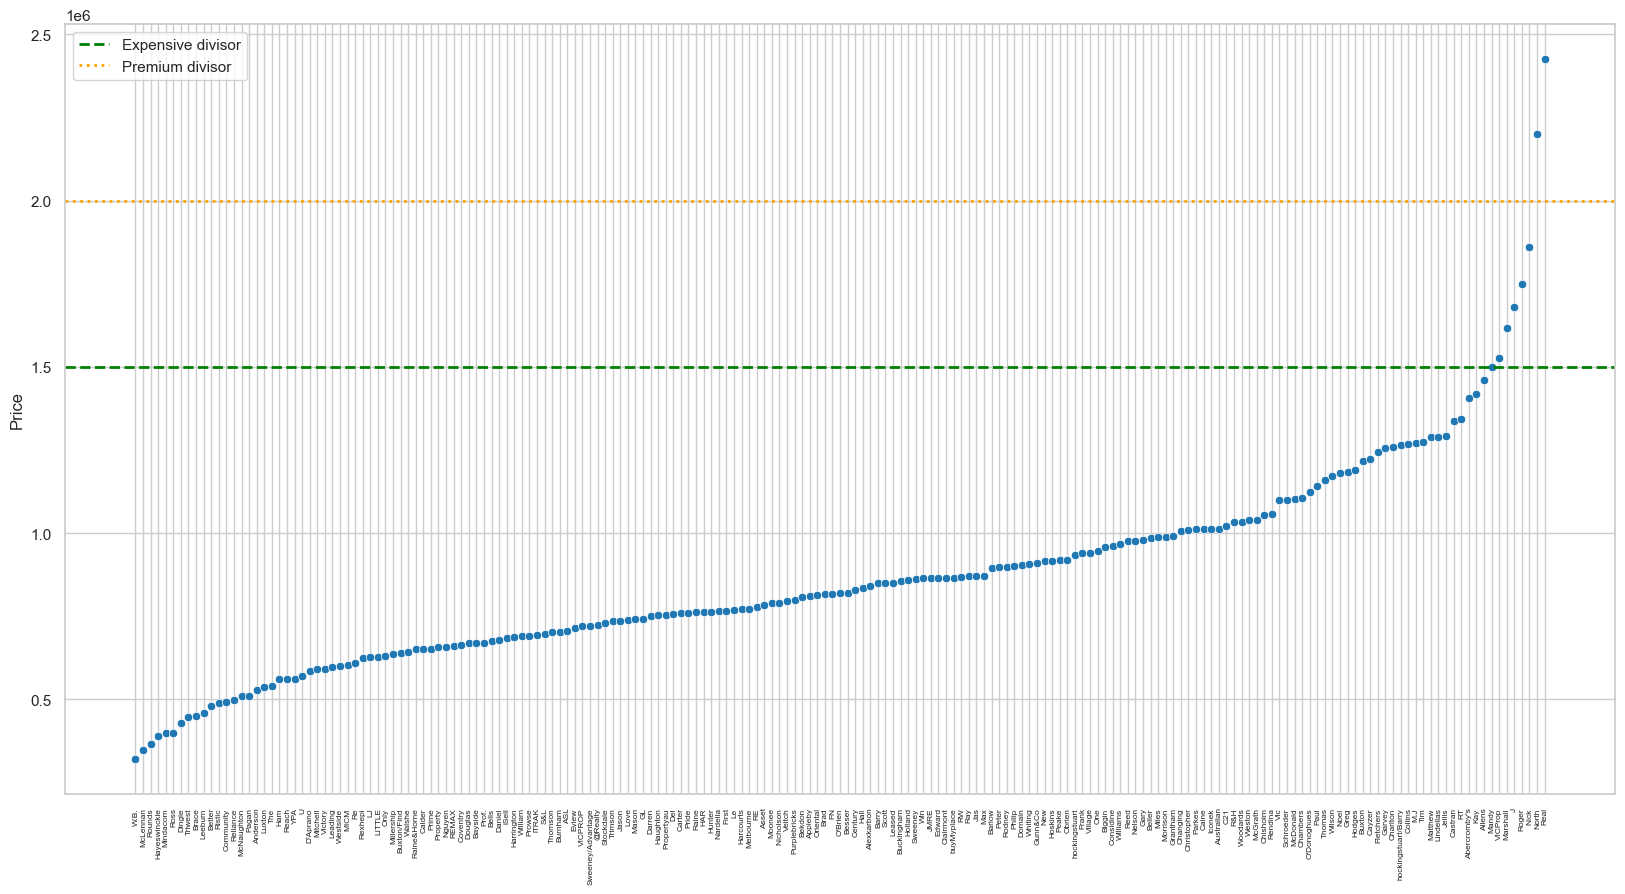

In [38]:
seller_pricing, _ = plot_distribution_grouped_field('SellerG')

### Suburb

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_49895/2525210817.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_pricing = train_set\


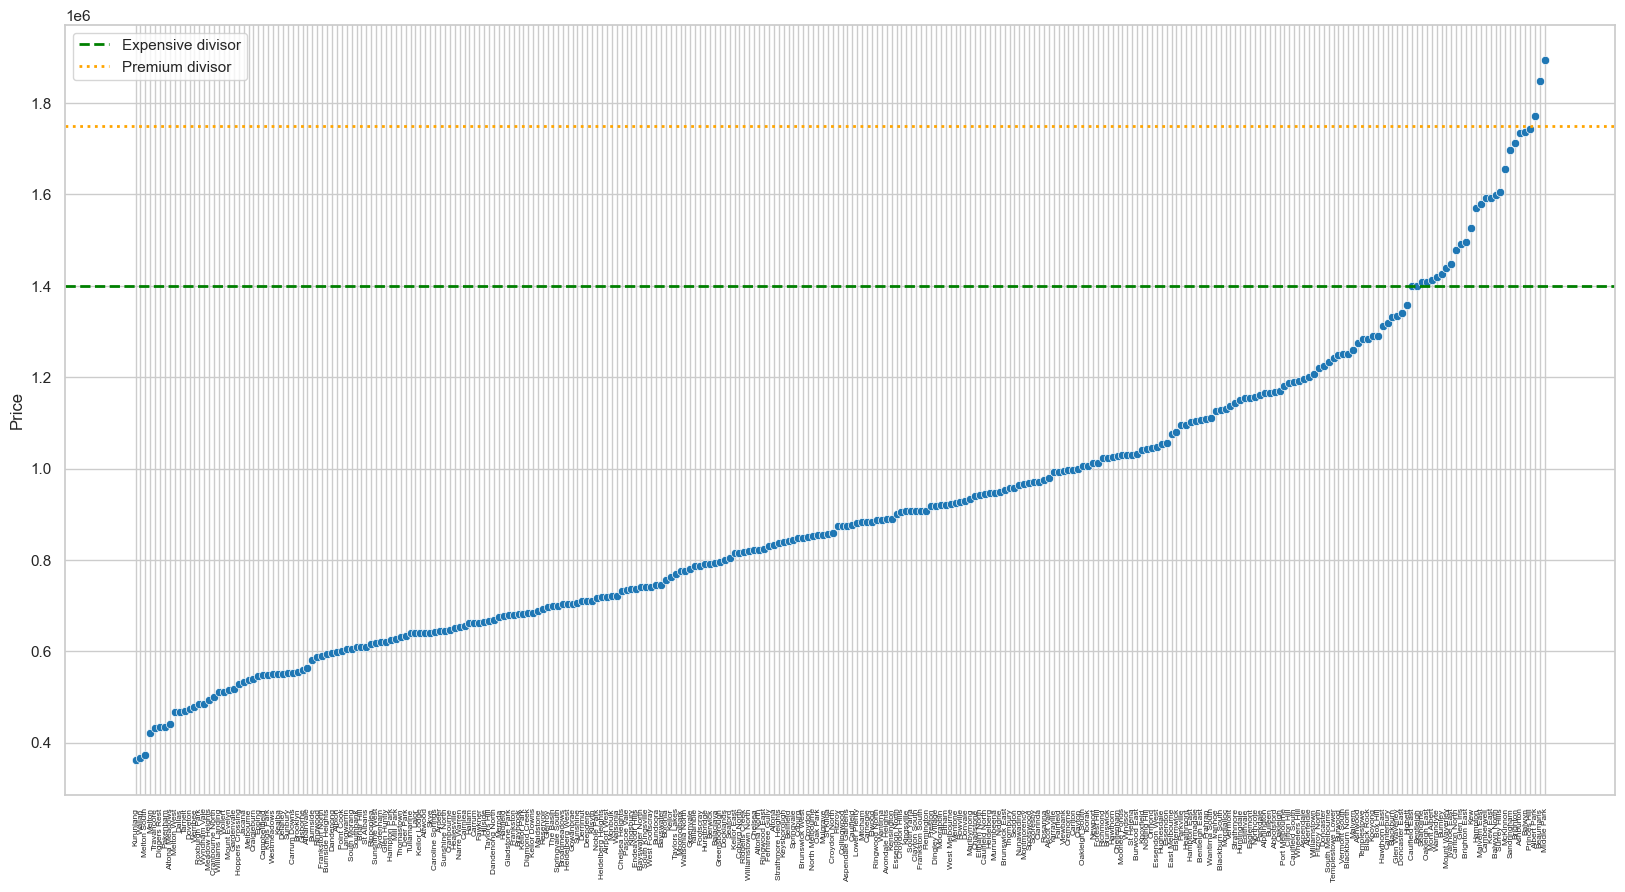

In [39]:
suburb_pricing, _ = plot_distribution_grouped_field(
    'Suburb', 
    expensive_divisor=1.4e6, 
    premium_divisor=1.75e6
)

### CouncilArea

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_49895/2525210817.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_pricing = train_set\


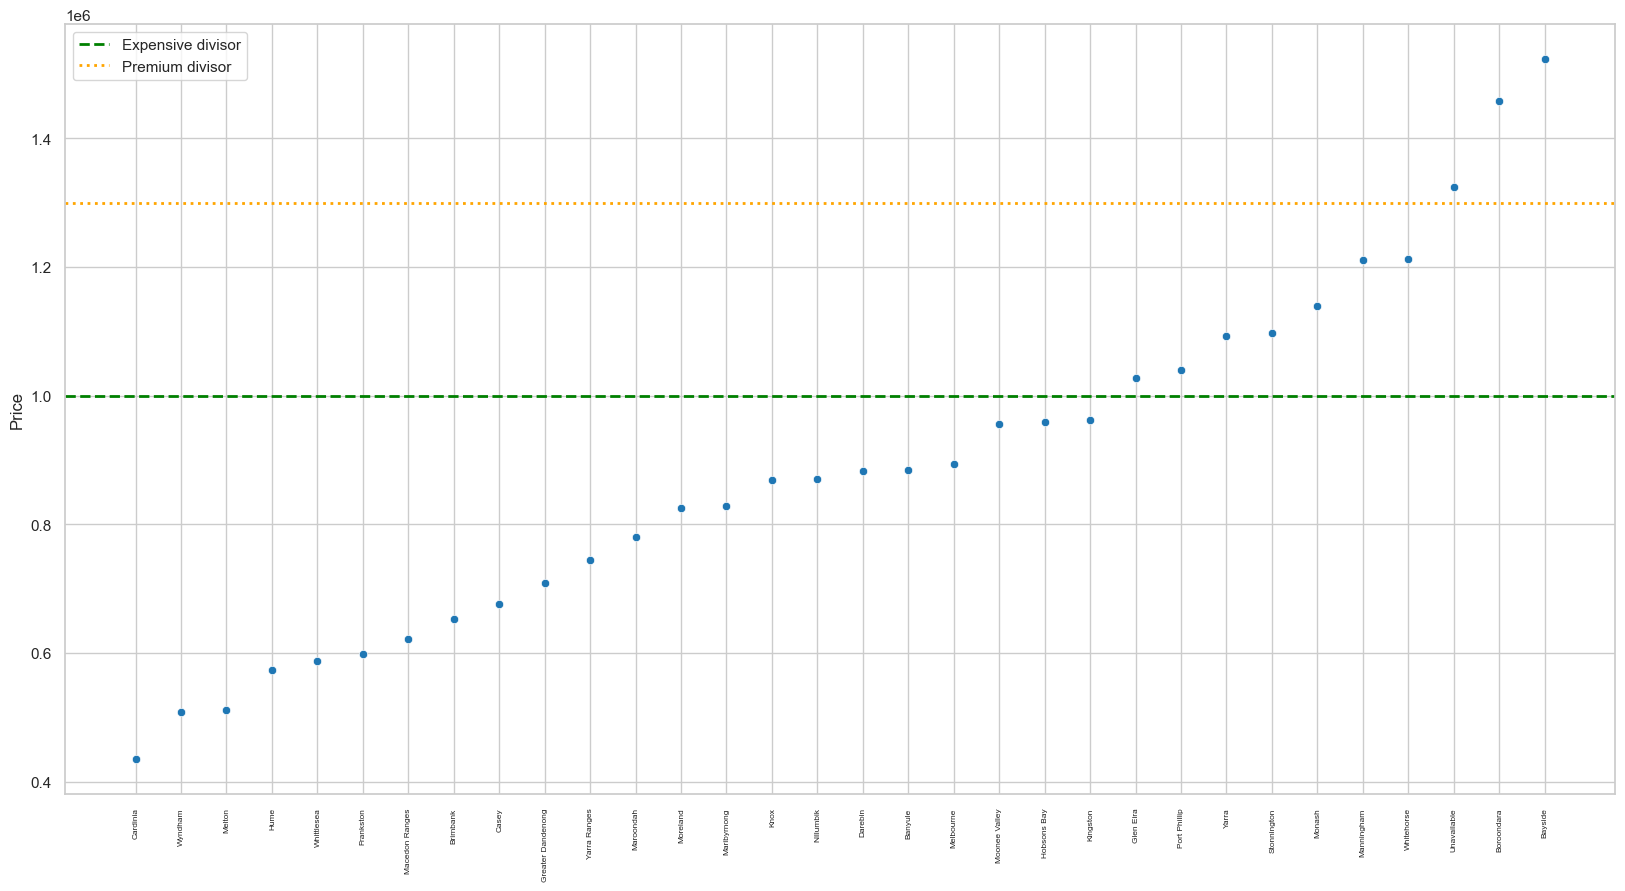

In [40]:
# TODO: Same idea for region name, councilArea & suburb (not just creating dummies for example in councilarea)
council_pricing, _ = plot_distribution_grouped_field('CouncilArea', expensive_divisor=1e6, premium_divisor=1.3e6)

## Numerical Variables

To start with this, we can first compute which is the correlation between the numerical variables.

<AxesSubplot:>

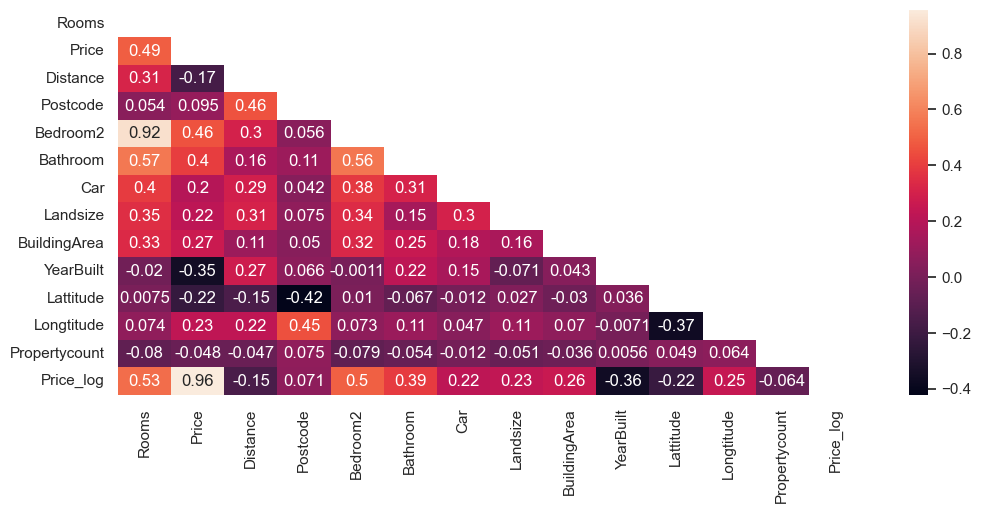

In [41]:
corr = train_set.corr(numeric_only=True)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(
    corr,
    annot=True,
    mask=matrix
)

So we can see that there are some variables with more correlation with price than logarithmic price:
- **Distance**
- **Bedroom2**
- **Bathroom**

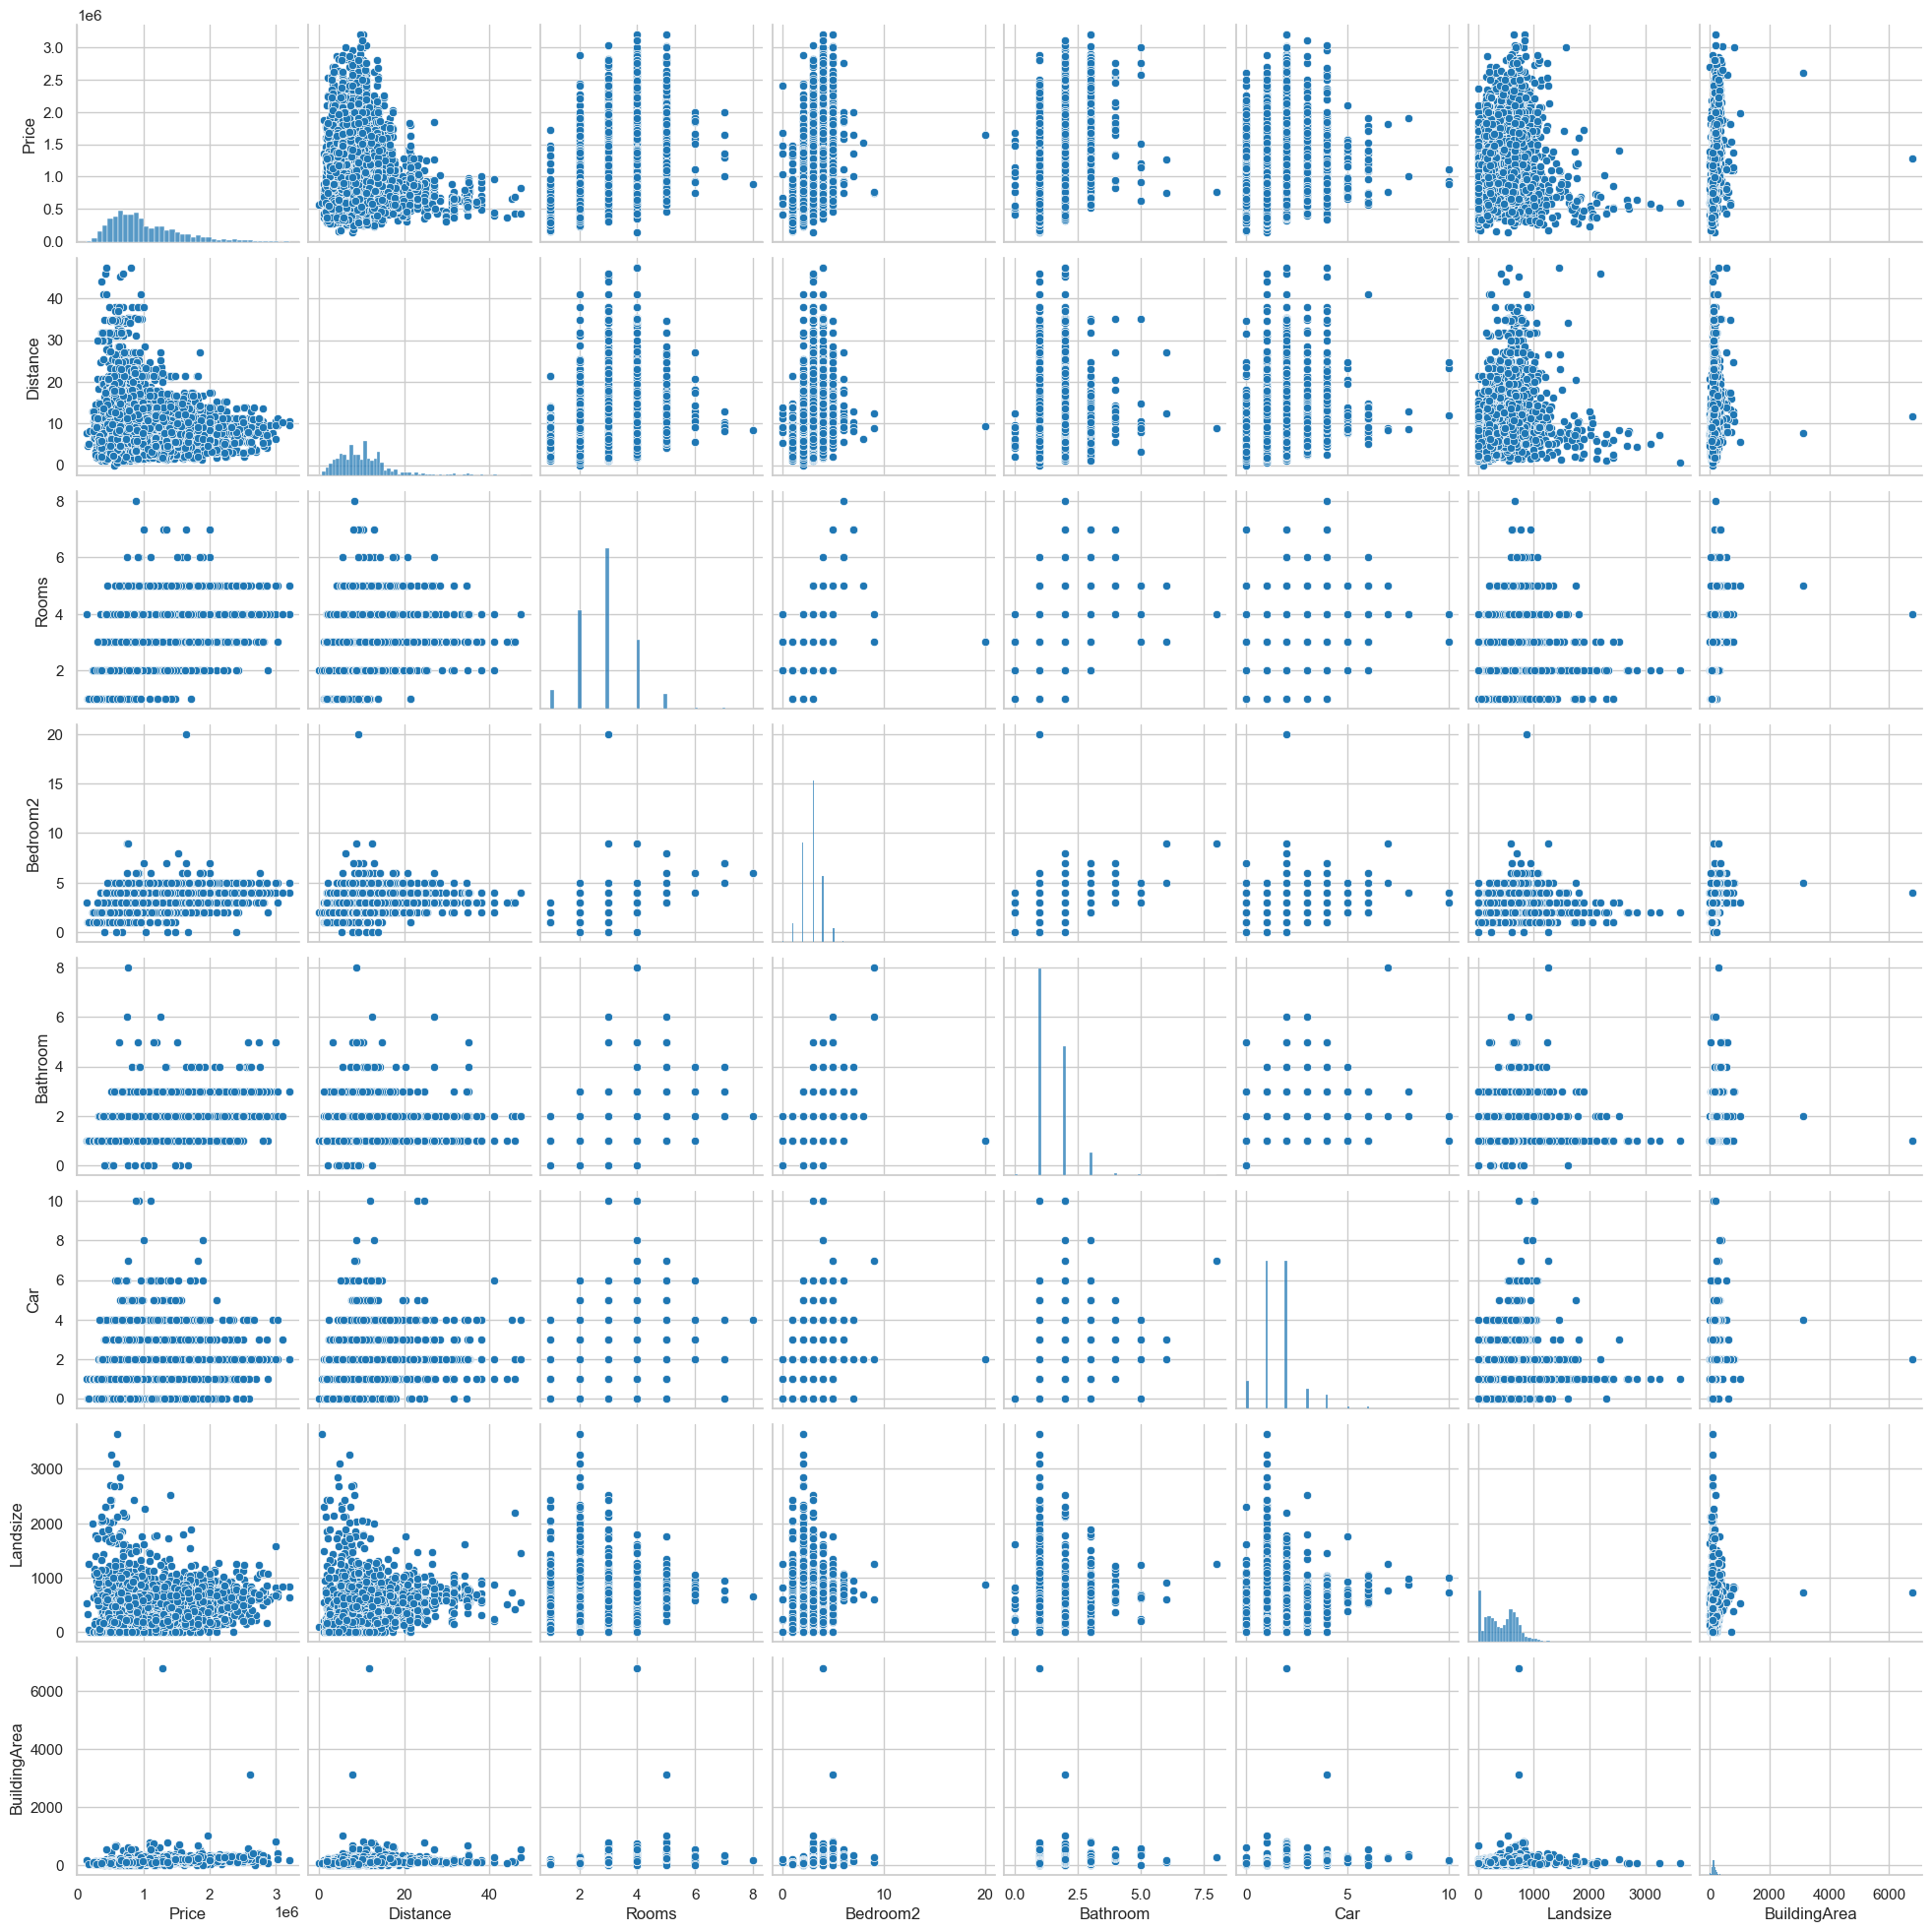

In [42]:
# We can create also pairplot so see how the distribution pairs are
sns.pairplot(
    train_set[['Price', 'Distance', 'Rooms', 'Bedroom2', 'Type', 'Bathroom', 'Car', 'Landsize', 'BuildingArea']]
)

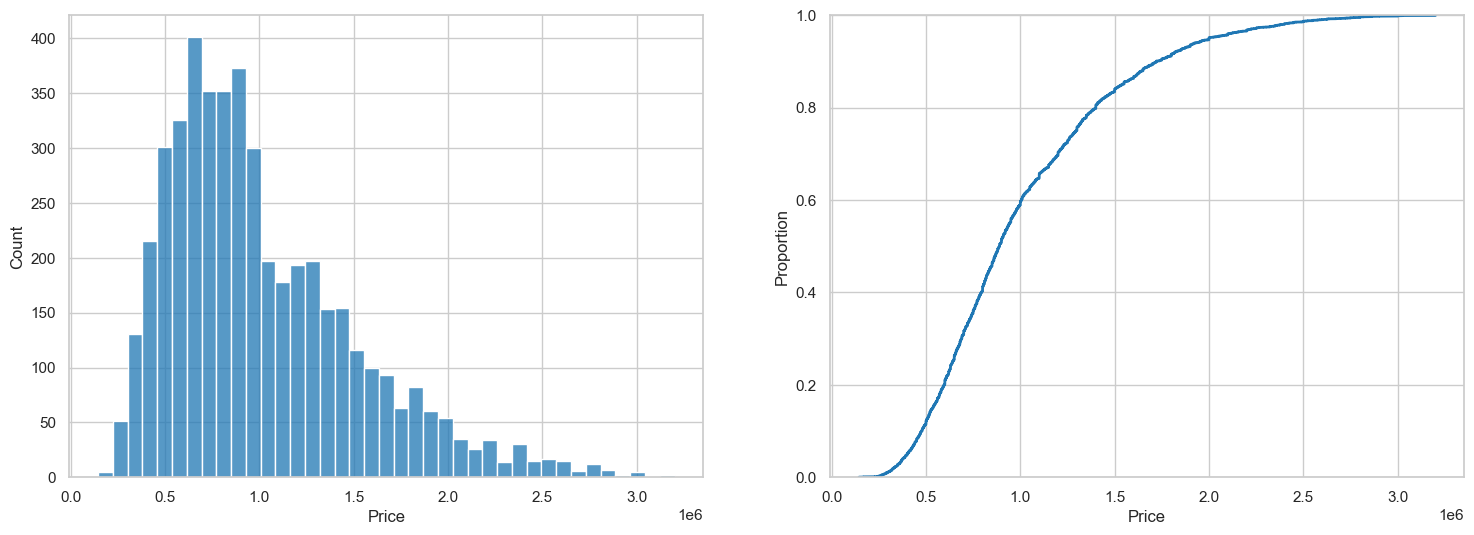

In [43]:
# We can plot more in detail the target variable
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(train_set['Price'], ax=ax1)
sns.ecdfplot(train_set['Price'], ax=ax2)
plt.show()

So we can see that more than 80% of the prices are below 150.000 dollars.

## Landsize & BuildingArea

In [44]:
# Will filter just for the purpose of the plot
train_set_filtered = train_set[train_set.BuildingArea.notna()]
train_set_filtered = train_set_filtered[train_set_filtered.BuildingArea > 0]
train_set_filtered = train_set_filtered[train_set_filtered.Landsize > 0]
train_set_filtered = train_set_filtered[train_set_filtered.Landsize < 10000]


#### TODO: Handle the -: maybe use landsize multiplier relation of something like that 

<AxesSubplot:xlabel='Landsize', ylabel='BuildingArea'>

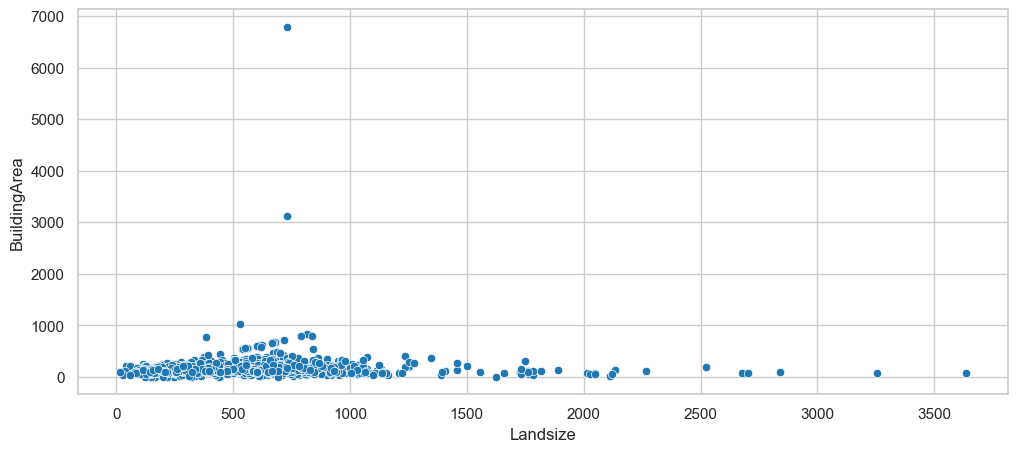

In [45]:
sns.scatterplot(
    x='Landsize',
    y='BuildingArea',
    data=train_set_filtered
)

## Relation property count

<AxesSubplot:>

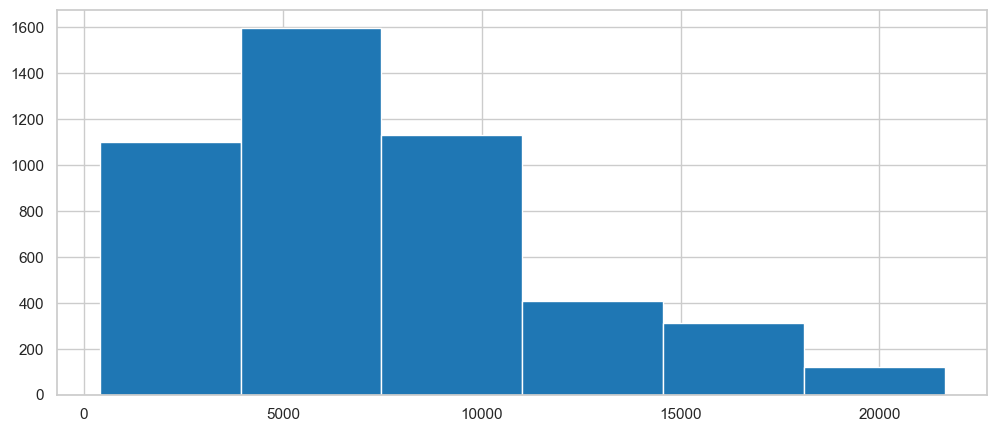

In [46]:
train_set.Propertycount.hist(bins=6)

In [47]:
# Will make use of this feature later

# Data Processing

## Handling NaN

In [48]:
def fill_target_nan_grouped_column(
    target: str, 
    grouped: str, 
    data: pd.DataFrame,
    statistic: str = 'median'
):

    data[target] = data[target]\
        .fillna(
            data\
                .groupby(grouped)[target]\
                .transform(statistic)
        )

    return data

In [49]:
def drop_column_na(
    data: pd.DataFrame,
    target: str,
):
    # Still some of them keep being NaN, we will drop them    
    return data

## Cars

<AxesSubplot:>

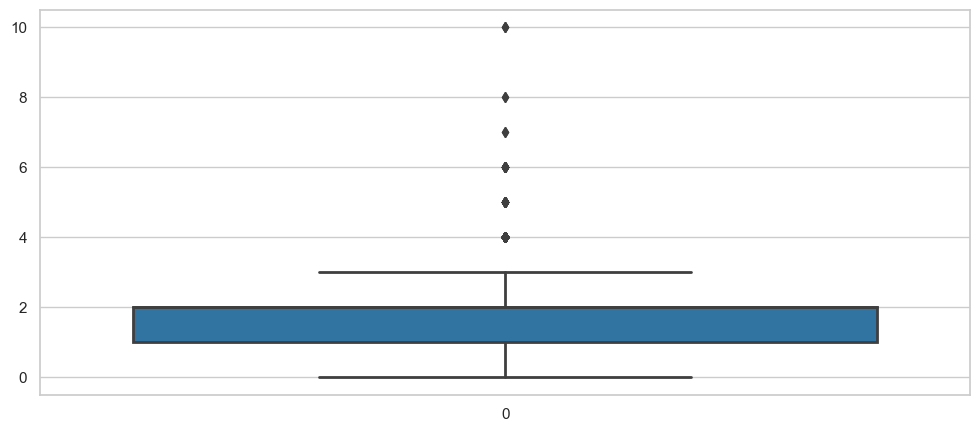

In [50]:
sns.boxplot(
    train_set['Car']
)

In [51]:
train_set_car_na = train_set[train_set['Car'].isna()]
train_set_car_na.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log
index,,,,,,,,,,,,,,,,,,,,,,
3011,Prahran,19 Porter St,1,u,515000.0,S,Biggin,16/09/2017,4.6,3181.0,1.0,1.0,NaN,284.0,NaN,NaN,NaN,-37.85018,144.99006,Southern Metropolitan,7717.0,13.151922
1182,Brunswick,1/208 Albion St,1,u,424000.0,SP,Jellis,26/08/2017,5.2,3056.0,1.0,1.0,NaN,334.0,80.0,2009.0,NaN,-37.76078,144.96168,Northern Metropolitan,11918.0,12.957489
998,Richmond,29 Type St,2,h,1200000.0,S,Biggin,16/09/2017,2.4,3121.0,2.0,1.0,NaN,135.0,86.0,1890.0,NaN,-37.82132,145.00973,Northern Metropolitan,14949.0,13.997832
899,Albert Park,59 Moubray St,3,h,2100000.0,VB,Cayzer,23/09/2017,3.0,3206.0,3.0,2.0,NaN,137.0,125.0,1890.0,NaN,-37.84388,144.95303,Southern Metropolitan,3280.0,14.557448
4482,Armadale,45 Northcote Rd,3,h,1450000.0,VB,hockingstuart,16/09/2017,6.3,3143.0,3.0,1.0,NaN,245.0,NaN,NaN,NaN,-37.85335,145.01698,Southern Metropolitan,4836.0,14.187074


<AxesSubplot:xlabel='Price', ylabel='Count'>

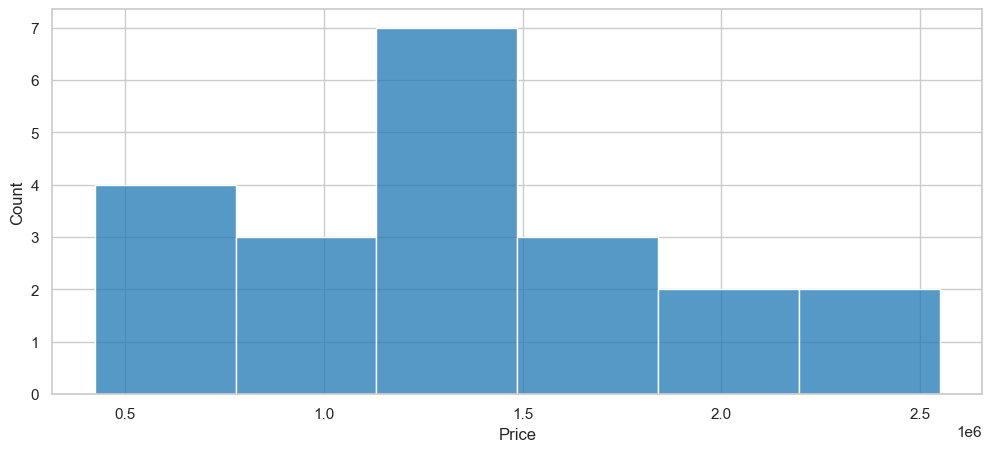

In [52]:
# Look at the price if those are observations of extreme relevance
sns.histplot(train_set_car_na['Price'])

In [53]:
# We can see that nearly half of them are from 19th century
train_set_car_na['YearBuilt'].value_counts()

1900.0    4
1890.0    3
2009.0    1
1910.0    1
1880.0    1
1970.0    1
1930.0    1
1990.0    1
Name: YearBuilt, dtype: int64

In [54]:
# For those, we assume that there where no cars in those houses
train_set.loc[
    (train_set['YearBuilt'] < 1940).index,
    'Car'
] = 0.0  

valid_set.loc[
    (valid_set['YearBuilt'] < 1940).index,
    'Car'
] = 0.0 

test_set.loc[
    (test_set['YearBuilt'] < 1940).index,
    'Car'
] = 0.0 

In [55]:
# For the other ones would place the median
train_set_car_median = train_set['Car'].median()

train_set['Car'].fillna(train_set_car_median, inplace=True)
valid_set['Car'].fillna(train_set_car_median, inplace=True)
test_set['Car'].fillna(train_set_car_median, inplace=True)

### YearBuilt

For the year built, we could compute the median of the years in which is was built each suburb. 

Assumming the construction was by areas, and each small area is represented by a suburb.

In [56]:
# Before doing so, we might want to see that the values of yearbuilt for each of suburbs are in quite close range
grouper = train_set.groupby("Suburb")['YearBuilt']
q1, q3 = grouper.quantile(0.25), grouper.quantile(0.75)
iqr = q3 - q1

The median interquantile range is:  17.5
The mean interquantile range is:  27.12881679389313


<AxesSubplot:>

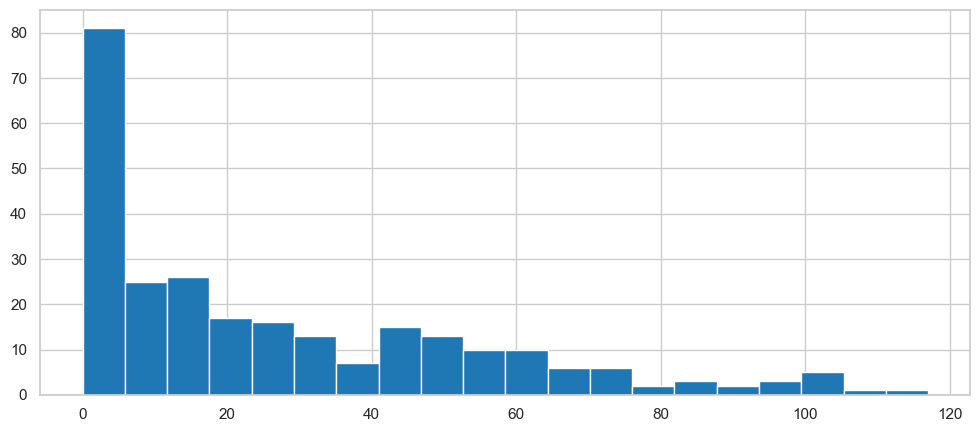

In [57]:
print('The median interquantile range is: ', iqr.median())
print('The mean interquantile range is: ', iqr.mean())

iqr.hist(bins=20)

In [58]:
train_set['SellerG'].nunique()

187

So it does not seem a good solution to replace the NaN with the median or the mean, as it has great variance.

Have tried **KNeighborsClassifier**, but has not worked very well.

In [59]:
train_set['Date'] = pd.to_datetime(train_set['Date'])
valid_set['Date'] = pd.to_datetime(valid_set['Date'])
test_set['Date'] = pd.to_datetime(test_set['Date'])

train_set['year_sold'] = train_set['Date'].dt.year
valid_set['year_sold'] = valid_set['Date'].dt.year
test_set['year_sold'] = test_set['Date'].dt.year

year_built_features = ['Lattitude', 'Longtitude', 'year_sold', 'Distance']
year_built_target = ['YearBuilt']

year_built_train_base = train_set.dropna(subset=year_built_target, axis=0, inplace=False)

year_built_train_nans_indices = train_set[year_built_target].isnull().values
year_built_train_nans = train_set[year_built_train_nans_indices]

In [60]:
# Explicative variables
year_built_train_base = year_built_train_base[year_built_features + year_built_target]
year_built_train_base_indices = year_built_train_base.index.values

year_built_train_nans = year_built_train_nans[year_built_features]

# Target variables
Y_year_built_train_base = year_built_train_base[year_built_target].values.ravel()
X_year_built_train_base = year_built_train_base.drop(year_built_target, axis=1)

In [61]:
# Create the model in the training data
year_built_model = DecisionTreeRegressor(
    random_state=0,
)

year_built_model.fit(
    X_year_built_train_base,
    Y_year_built_train_base,
)

DecisionTreeRegressor(random_state=0)

In [62]:
year_built_nans_pred = year_built_model.predict(year_built_train_nans)

In [63]:
train_set.loc[
    year_built_train_nans_indices.ravel(),
    'YearBuilt'
] = year_built_nans_pred

In [64]:
# TODO: Automatize this with a function/imputer 

Apply this model for the validation.

In [65]:
# We will use this classifier to infer the NaNs that we have in train, valid and test
year_built_valid_base = valid_set.dropna(subset=year_built_target, axis=0, inplace=False)

year_built_valid_nans_indices = valid_set[year_built_target].isnull().values
year_built_valid_nans = valid_set[year_built_valid_nans_indices]

# Explicative variables
year_built_valid_base = year_built_valid_base[year_built_features + year_built_target]
year_built_valid_base_indices = year_built_valid_base.index.values

year_built_valid_nans = year_built_valid_nans[year_built_features]

# Target variables
Y_year_built_valid_base = year_built_valid_base[year_built_target].values.ravel()
X_year_built_valid_base = year_built_valid_base.drop(year_built_target, axis=1)

In [66]:
# Can assess the model accuracy on staging
from sklearn.metrics import mean_absolute_error

year_built_valid_pred = year_built_model.predict(X_year_built_valid_base)
mean_absolute_error(Y_year_built_valid_base, year_built_valid_pred)

33.491176470588236

In [67]:
valid_set.loc[
    year_built_valid_nans_indices.ravel(),
    'YearBuilt'
] = year_built_model.predict(year_built_valid_nans)

And apply if for the testing as well.

In [68]:
# We will use this classifier to infer the NaNs that we have in train, valid and test
year_built_test_base = test_set.dropna(subset=year_built_target, axis=0, inplace=False)

year_built_test_nans_indices = test_set[year_built_target].isnull().values
year_built_test_nans = test_set[year_built_test_nans_indices]

# Explicative variables
year_built_test_base = year_built_test_base[year_built_features + year_built_target]
year_built_test_base_indices = year_built_test_base.index.values

year_built_test_nans = year_built_test_nans[year_built_features]

# Target variables
Y_year_built_test_base = year_built_test_base[year_built_target].values.ravel()
X_year_built_test_base = year_built_test_base.drop(year_built_target, axis=1)

In [69]:
test_set.loc[
    year_built_test_nans_indices.ravel(),
    'YearBuilt'
] = year_built_model.predict(year_built_test_nans)

### BuildingArea

We can build a regression model for predicting which is the Building Area.

We can infer some outliers for both the Landsize and Building Area.

This is why we are going to use the **Logistic Regression** / DecisionTreeRegressor, as with for example Linear Regressions we were having negative values.

In [70]:
def get_df_valid_size(df: pd.DataFrame, column: str):
    return df[
        (~df[column].isnull()) &
        (df[column] > 0)
    ]

def get_df_invalid_size(df: pd.DataFrame, column: str):
    return df[
        (df[column].isnull()) |
        (df[column] <= 0)
    ]

In [71]:
building_area_train_base = get_df_valid_size(train_set, 'BuildingArea')

In [72]:
# Simple model
building_area_features = ['Bedroom2', 'Bathroom', 'Propertycount']  # very simple model

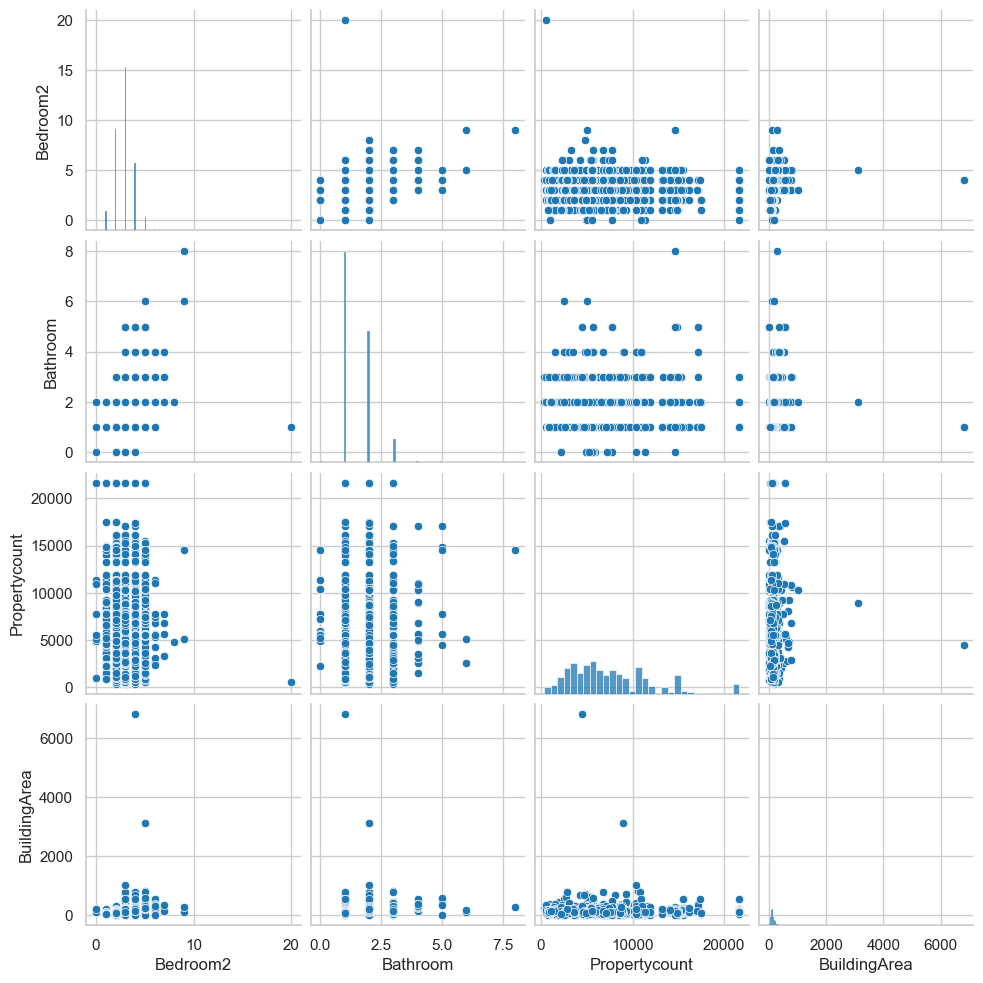

In [73]:
sns.pairplot(train_set[building_area_features + ['BuildingArea']])

In [74]:
Y_building_area_train_base = building_area_train_base.BuildingArea
X_building_area_train_base = building_area_train_base[building_area_features]
building_area_train_base.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log,year_sold
index,,,,,,,,,,,,,,,,,,,,,,,
5059,Essendon,27 Miller St,3,h,1320000.0,S,Rendina,2017-03-06,7.5,3040.0,3.0,2.0,0.0,276.0,149.0,1910.0,Moonee Valley,-37.75126,144.89558,Western Metropolitan,9264.0,14.093142,2017
140,Altona,1/123 Blyth St,2,t,720000.0,S,hockingstuart,2016-04-02,13.8,3018.0,2.0,1.0,0.0,292.0,125.0,2013.0,Hobsons Bay,-37.86870,144.81970,Western Metropolitan,5301.0,13.487006,2016
1850,Werribee,3 Parramatta Rd,3,h,452000.0,SP,Biggin,2017-07-22,14.7,3030.0,3.0,1.0,0.0,567.0,121.0,1980.0,Wyndham,-37.88666,144.66149,Western Metropolitan,16166.0,13.021437,2017


In [75]:
scaler = StandardScaler()
X_building_area_train_base = scaler.fit_transform(X_building_area_train_base)

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [77]:
model_rf_ba = RandomForestRegressor()

space = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': [3, 5, 6, 10],
    'min_samples_leaf': [3, 5, 8, 10]
}

model_rf_ba_search = RandomizedSearchCV(
    estimator=model_rf_ba, 
    param_distributions=space, 
    scoring='neg_mean_absolute_error',
    n_iter=30,
    n_jobs=-1,
    cv=3,
    random_state=42
)

model_rf_ba_search.fit(X_building_area_train_base, Y_building_area_train_base)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 6, 10],
                                        'min_samples_leaf': [3, 5, 8, 10],
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   random_state=42, scoring='neg_mean_absolute_error')

In [78]:
model_rf_ba_search.best_score_

-39.89221433669878

In [79]:
# And now we can compute the predictions
building_area_train_target = get_df_invalid_size(train_set, 'BuildingArea')
building_area_train_target = building_area_train_target[building_area_features]
building_area_train_target_index = building_area_train_target.index 

building_area_train_target = scaler.transform(building_area_train_target)

In [80]:
train_set.loc[building_area_train_target_index, 'BuildingArea'] = model_rf_ba_search.predict(building_area_train_target)

<AxesSubplot:>

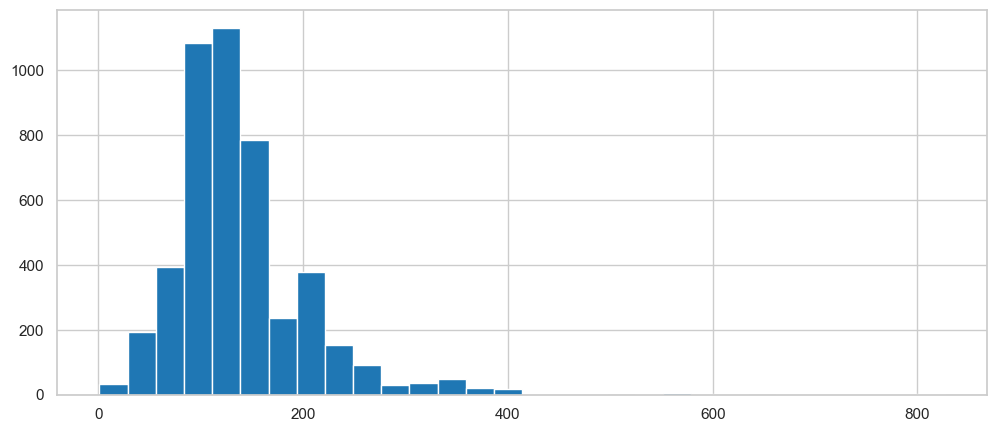

In [81]:
train_set[train_set['BuildingArea'] < 1e3]['BuildingArea'].hist(bins=30)

In [82]:
train_set['BuildingArea'].describe()

count    4668.000000
mean      141.538905
std       129.713976
min         1.000000
25%        88.000000
50%       127.000810
75%       159.181500
max      6791.000000
Name: BuildingArea, dtype: float64

In [83]:
# And now we fill the nan for the valid & testing
building_area_valid_target = get_df_invalid_size(valid_set, 'BuildingArea')

In [84]:
if len(building_area_valid_target) > 0:
    building_area_valid_target = building_area_valid_target[building_area_features]
    building_area_valid_target_index = building_area_valid_target.index 

    building_area_valid_target = scaler.transform(building_area_valid_target)

    valid_set.loc[building_area_valid_target_index, 'BuildingArea'] = model_rf_ba_search.predict(building_area_valid_target)

In [85]:
building_area_test_target = get_df_invalid_size(test_set, 'BuildingArea')

if len(building_area_test_target) > 0:
    building_area_test_target = building_area_test_target[building_area_features]
    building_area_test_target_index = building_area_test_target.index 

    building_area_test_target = scaler.transform(building_area_test_target)

    test_set.loc[building_area_test_target_index, 'BuildingArea'] = model_rf_ba_search.predict(building_area_test_target)

In [86]:
from typing import List

# Will create a function that automatizes this part
def random_forecast_imputer(
    target_col: str,
    train_df: pd.DataFrame,
    valid_df: pd.DataFrame,
    test_df: pd.DataFrame,
    feature_cols: List[str] = ['Bedroom2', 'Bathroom', 'Propertycount']
):
    
    # Getting the valid base for training
    train_base = get_df_valid_size(train_df, target_col)
    Y_train_base = train_base[target_col]
    X_train_base = train_base[feature_cols]
    
    scaler = StandardScaler()
    X_train_base = scaler.fit_transform(X_train_base)
    
    # Create the model & train it
    model_rf = RandomForestRegressor()

    space = {
        'n_estimators': np.arange(100, 1000, 100),
        'max_depth': [3, 5, 6, 10],
        'min_samples_leaf': [3, 5, 8, 10]
    }

    model_rf_search = RandomizedSearchCV(
        estimator=model_rf, 
        param_distributions=space, 
        scoring='neg_mean_absolute_error',
        n_iter=30,
        n_jobs=-1,
        cv=3,
        random_state=42
    )

    model_rf_search.fit(X_train_base, Y_train_base)
    
    print('Best score: ', model_rf_search.best_score_)
    
    # And now with training
    train_target = get_df_invalid_size(train_df, target_col)
    train_target = train_target[feature_cols]
    train_target_index = train_target.index 

    train_target = scaler.transform(train_target)
    
    train_df.loc[train_target_index, target_col] = model_rf_search.predict(train_target)
    print('Imputed in train: ', len(train_target_index))
    
    # For validation
    valid_target = get_df_invalid_size(valid_df, target_col)
    if len(valid_target) > 0:
        valid_target = valid_target[feature_cols]
        valid_target_index = valid_target.index 

        valid_target = scaler.transform(valid_target)

        valid_df.loc[valid_target_index, target_col] = model_rf_search.predict(valid_target)
        print('Imputed in validation: ', len(valid_target_index))

    
    # For testing
    test_target = get_df_invalid_size(test_df, target_col)
    
    if len(test_target) > 0:
        test_target = test_target[feature_cols]
        test_target_index = test_target.index 

        test_target = scaler.transform(test_target)

        test_df.loc[test_target_index, target_col] = model_rf_search.predict(test_target)
        print('Imputed in testing: ', len(test_target_index))
    
    return train_df, valid_df, test_df

### Land Size

In [87]:
# We apply the same imputer we had before
train_set, valid_set, test_set = random_forecast_imputer(
    target_col='Landsize',
    train_df=train_set,
    valid_df=valid_set,
    test_df=test_set,
)

Best score:  -201.70206006991384
Imputed in train:  652
Imputed in validation:  79
Imputed in testing:  1193


<AxesSubplot:>

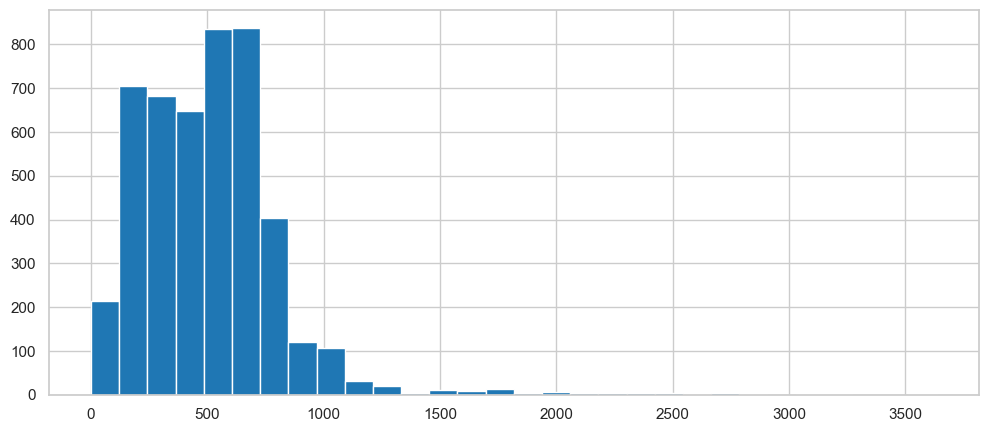

In [88]:
train_set[train_set['Landsize'] < 1e4]['Landsize'].hist(bins=30)

In [89]:
train_set['Landsize'].describe()

count    4668.000000
mean      508.505990
std       301.530323
min         1.000000
25%       283.750000
50%       504.430593
75%       664.000000
max      3634.000000
Name: Landsize, dtype: float64

### Council Area

This rea is strictly related to the longtitude and lattitude.

So we will create a **KNN algorithm**, that extract the information that we want from the coordinates.

NOTE: Not doing Validation as want to extract all possible information from the set.

In [90]:
train_set_base = train_set.dropna(subset=['CouncilArea'])
train_set_target = train_set[train_set['CouncilArea'].isna()]

# Explicative variables
X_train_base_set_council = train_set_base[['Lattitude', 'Longtitude']]
X_train_target_set_council = train_set_target[['Lattitude', 'Longtitude']]
X_train_target_set_council_index = X_train_target_set_council.index

# Target variables
Y_train_base_set_council = train_set_base['CouncilArea'].values.ravel()

In [91]:
X_train_base_set_council.isnull().sum(axis=0)

Lattitude     0
Longtitude    0
dtype: int64

In [92]:
scaler = MinMaxScaler()

X_train_base_set_council = scaler.fit_transform(X_train_base_set_council)
X_train_target_set_council = scaler.transform(X_train_target_set_council)

In [93]:
n_council_area = train_set['CouncilArea'].nunique()
knn_council_area = KNeighborsClassifier(n_council_area)

knn_council_area.fit(X_train_base_set_council, Y_train_base_set_council)

KNeighborsClassifier(n_neighbors=32)

In [94]:
knn_council_area.score(X_train_base_set_council, Y_train_base_set_council)
# TODO: HP tuning to try improve this classification
# TODO: Train/Val split?

0.9308943089430894

In [95]:
# And now we predict for the test set, which is the one with NaN
council_pred = knn_council_area.predict(X_train_target_set_council)

In [96]:
# And finally we replace the council area of the train set
train_set.loc[X_train_target_set_council_index, 'CouncilArea'] = council_pred

In [97]:
# Assert there are no more NaN in train set
train_set['CouncilArea'].isna().sum()

0

**NOTE**: In test_set, we would need to use same classifier for the Council Area.

In [98]:
valid_set_target = valid_set[valid_set['CouncilArea'].isna()][['Lattitude', 'Longtitude']]
valid_set_target_trans = scaler.transform(valid_set_target)
valid_council_pred = knn_council_area.predict(valid_set_target_trans)
valid_set.loc[valid_set_target.index, 'CouncilArea'] = valid_council_pred

In [99]:
# Get which is the data needed to make the inference
test_set_target = test_set[test_set['CouncilArea'].isna()][['Lattitude', 'Longtitude']]
test_set_target_trans = scaler.transform(test_set_target)
test_council_pred = knn_council_area.predict(test_set_target_trans)
test_set.loc[test_set_target.index, 'CouncilArea'] = test_council_pred

In [100]:
print(train_set.dtypes.to_string())

Suburb                   object
Address                  object
Rooms                     int64
Type                     object
Price                   float64
Method                   object
SellerG                  object
Date             datetime64[ns]
Distance                float64
Postcode                float64
Bedroom2                float64
Bathroom                float64
Car                     float64
Landsize                float64
BuildingArea            float64
YearBuilt               float64
CouncilArea              object
Lattitude               float64
Longtitude              float64
Regionname               object
Propertycount           float64
Price_log               float64
year_sold                 int64


# Feature Engineering

Date Feature Enginering:
- Years difference between sold and built
- ratios of beds/rooms, rooms/bathrooms, buildingarea/land, ...
- Use **distance** to DBD (Central Business District: central commercial streets and main public buildings)
- **Seller** names: could group them depending on the size of the houses for example if there is a relation (premium sellers -> would have higher price). Or group sellers in groups of selling houses above mean price/buildingarea_or_land of each of the council-area (so in some council areas we would have some premium sellers, and in others we would have other ones), in range and below that mean for example.
- Create one predicting model for each group of sellers/councils/group areas similarity.

Normalization of features (for LR, in case of Trees not be necessary).

PCA.

In [101]:
train_set_extended = train_set.copy()
valid_set_extended = valid_set.copy()
test_set_extended = test_set.copy()

## Property Count

In [102]:
_, pc_bins = pd.qcut(train_set_extended['Propertycount'], 9, labels=False, retbins=True)

train_set_extended['prop_count_bkt'] = pd.cut(
    train_set_extended['Propertycount'], 
    bins=pc_bins, 
    labels=range(len(pc_bins)-1),
    include_lowest=True
)

valid_set_extended['prop_count_bkt'] = pd.cut(
    valid_set_extended['Propertycount'], 
    bins=pc_bins, 
    labels=range(len(pc_bins)-1),
    include_lowest=True
)

test_set_extended['prop_count_bkt'] = pd.cut(
    test_set_extended['Propertycount'], 
    bins=pc_bins, 
    labels=range(len(pc_bins)-1),
    include_lowest=True
)
test_set_extended['prop_count_bkt'].fillna(0.0, inplace=True) # one of 250

<AxesSubplot:>

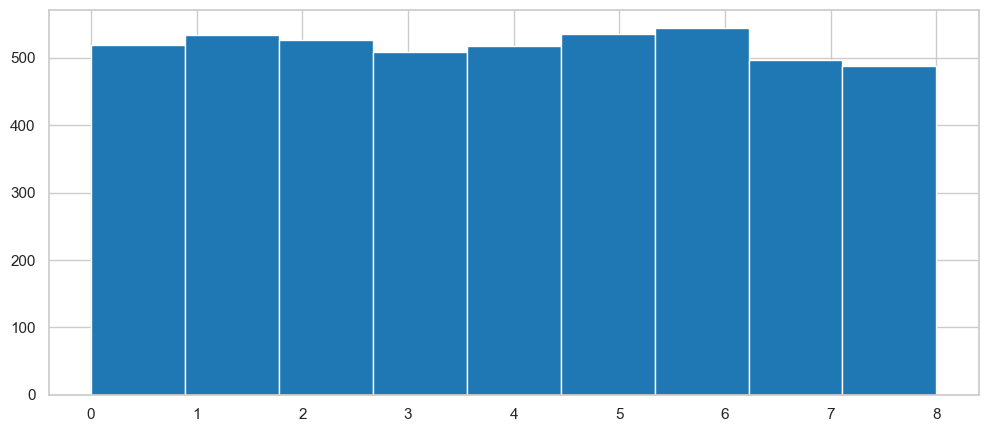

In [103]:
train_set_extended['prop_count_bkt'].hist(bins=9)

In [104]:
train_set_extended.prop_count_bkt = train_set_extended.prop_count_bkt.astype('int8')
valid_set_extended.prop_count_bkt = valid_set_extended.prop_count_bkt.astype('int8')
test_set_extended.prop_count_bkt = test_set_extended.prop_count_bkt.astype('int8')

In [105]:
pc_features = ['prop_count_bkt']
pc_features_to_drop = ['Propertycount']

## SellerG, Suburb & Council Area

In [106]:
def classify_category(
    group_pricing, 
    df: pd.DataFrame,
    input_column_name: str,
    output_column_name: str,
    premium_threshold = 2e6,
    expensive_threshold = 1.5e6,
    
):
    
    # We get the group names
    premium_group = list(
        group_pricing[group_pricing >= premium_threshold].index.values
    )
    
    expensive_group = list(
        group_pricing[
            (group_pricing >= expensive_threshold) & 
            (group_pricing < premium_threshold)
        ].index.values
    )
    
    normal_group = list(
        group_pricing[group_pricing < expensive_threshold].index.values
    )
    
    # And now we make the classification
    df.loc[
        df[input_column_name].isin(premium_group), 
        output_column_name
    ] = 2

    df.loc[
        df[input_column_name].isin(expensive_group), 
        output_column_name
    ] = 1

    df.loc[
        df[input_column_name].isin(normal_group), 
        output_column_name
    ] = 0
    
    # And in the case some of it has not been classified: -1 as we consider them less than normal
    df[output_column_name].fillna(-1, inplace=True)
    
    return df

### SellerG

In [107]:
train_set_extended = classify_category(
    df=train_set_extended,
    group_pricing=seller_pricing,
    input_column_name='SellerG',
    output_column_name='seller_class',
    premium_threshold=2e6,
    expensive_threshold=1.5e6,
)

valid_set_extended = classify_category(
    df=valid_set_extended,
    group_pricing=seller_pricing,
    input_column_name='SellerG',
    output_column_name='seller_class',
    premium_threshold=2e6,
    expensive_threshold=1.5e6,
)

test_set_extended = classify_category(
    df=test_set_extended,
    group_pricing=seller_pricing,
    input_column_name='SellerG',
    output_column_name='seller_class',
    premium_threshold=2e6,
    expensive_threshold=1.5e6,
)

In [108]:
seller_features = ['seller_class']
seller_features_to_drop = ['SellerG']

### Suburb

In [109]:
train_set_extended = classify_category(
    df=train_set_extended,
    group_pricing=suburb_pricing,
    input_column_name='Suburb',
    output_column_name='suburb_class',
    premium_threshold=1.75e6,
    expensive_threshold=1.4e6,
)

valid_set_extended = classify_category(
    df=valid_set_extended,
    group_pricing=suburb_pricing,
    input_column_name='Suburb',
    output_column_name='suburb_class',
    premium_threshold=1.75e6,
    expensive_threshold=1.4e6,
)

test_set_extended = classify_category(
    df=test_set_extended,
    group_pricing=suburb_pricing,
    input_column_name='Suburb',
    output_column_name='suburb_class',
    premium_threshold=1.75e6,
    expensive_threshold=1.4e6,
)

In [110]:
suburb_features = ['suburb_class']
suburb_features_to_drop = ['Suburb']  # will not make use of this one

### Council Area

In [111]:
train_set_extended = classify_category(
    df=train_set_extended,
    group_pricing=council_pricing,
    input_column_name='CouncilArea',
    output_column_name='council_class',
    premium_threshold=1e6,
    expensive_threshold=1.3e6,
)

valid_set_extended = classify_category(
    df=valid_set_extended,
    group_pricing=council_pricing,
    input_column_name='CouncilArea',
    output_column_name='council_class',
    premium_threshold=1e6,
    expensive_threshold=1.3e6,
)

test_set_extended = classify_category(
    df=test_set_extended,
    group_pricing=council_pricing,
    input_column_name='CouncilArea',
    output_column_name='council_class',
    premium_threshold=1e6,
    expensive_threshold=1.3e6,
)

In [112]:
council_features = ['council_class']
council_features_to_drop = ['CouncilArea']  # will not make use of this one

## Region Name

In [113]:
train_set.Regionname.value_counts()

Southern Metropolitan         1554
Northern Metropolitan         1314
Western Metropolitan          1061
Eastern Metropolitan           516
South-Eastern Metropolitan     175
Eastern Victoria                21
Western Victoria                14
Northern Victoria               13
Name: Regionname, dtype: int64

In [114]:
grouped_regions = {
    'Southern Metropolitan': 'southern_metropolitan',
    'Northern Metropolitan': 'northern_metropolitan',
    'Western Metropolitan': 'western_metropolitan',
    'Eastern Metropolitan': 'eastern_metropolitan',
    'South-Eastern Metropolitan': 'eastern_metropolitan',  # grouped with the one above
    'Eastern Victoria': 'other',
    'Western Victoria': 'other',
    'Northern Victoria': 'other'
}

In [115]:
def set_grouped_region(df: pd.DataFrame):
    for idx, row in df.iterrows():
        df.loc[
            idx,
            grouped_regions[row['Regionname']]  # in the new column we want
        ] = 1
        
    unique_columns = list(set(grouped_regions.values()))
    df[unique_columns] = df[unique_columns].fillna(value=0)
    df[unique_columns] = df[unique_columns].astype('int8')
    
    return df

In [116]:
train_set_extended = set_grouped_region(train_set_extended)
valid_set_extended = set_grouped_region(valid_set_extended)
test_set_extended = set_grouped_region(test_set_extended)

In [117]:
region_features = [
    'southern_metropolitan', 
    'northern_metropolitan', 
    'western_metropolitan', 
    'eastern_metropolitan', 
    'other'
]

region_features_to_drop = ['Regionname']  # will not make use of this one

## Dates

In [118]:
# Adding information about which is the day, week and year
def temporal_info(data: pd.DataFrame):
    # Convert to datetime
    data['Date'] = pd.to_datetime(data['Date'])
    
    data['year_sold'] = data.Date.dt.year.astype("int32")
    data['month_sold'] = data.Date.dt.month.astype("int8")
    data['quarter_sold'] = data.Date.dt.quarter.astype("int8")
    data['day_of_week_sold'] = (data.Date.dt.dayofweek + 1).astype("int8")
    data['day_of_month_sold'] = data.Date.dt.day.astype("int8")
    data['day_of_year_sold'] = data.Date.dt.dayofyear.astype("int16")
    data['week_of_month_sold'] = (data.Date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    data['week_of_year_sold'] = (data.Date.dt.weekofyear).astype("int8")
    
    date_features = [
        'year_sold',
        'month_sold',
        'quarter_sold',
        'day_of_week_sold',
        'day_of_month_sold',
        'day_of_year_sold',
        'week_of_month_sold',
        'week_of_year_sold'
    ]
    
    return data, date_features

train_set_extended, date_features = temporal_info(train_set_extended)
valid_set_extended, _ = temporal_info(valid_set_extended)
test_set_extended, _ = temporal_info(test_set_extended)

/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_49895/2938933862.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['week_of_year_sold'] = (data.Date.dt.weekofyear).astype("int8")
/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_49895/2938933862.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['week_of_year_sold'] = (data.Date.dt.weekofyear).astype("int8")
/var/folders/p0/12vcby4x6nxfqn51s513m16c0000gn/T/ipykernel_49895/2938933862.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['week_of_year_sold'] = (data.Date.dt.weekofyear).astype("int8")


In [119]:
# Adding information relative to which is that date
def relevant_dates_info(data: pd.DataFrame):
    data['is_wknd'] = (data.Date.dt.weekday // 4).astype("int8")
    data['is_month_start'] = data.Date.dt.is_month_start.astype("int8")
    data['is_month_end'] = data.Date.dt.is_month_end.astype("int8")
    data['is_quarter_start'] = data.Date.dt.is_quarter_start.astype("int8")
    data['is_quarter_end'] = data.Date.dt.is_quarter_end.astype("int8")
    data['is_year_start'] = data.Date.dt.is_year_start.astype("int8")
    data['is_year_end'] = data.Date.dt.is_year_end.astype("int8")
    
    date_features = [
        'is_wknd',
        'is_month_start',
        'is_month_end',
        'is_quarter_start',
        'is_quarter_end',
        'is_year_start',
        'is_year_end'
    ]
    
    return data, date_features

train_set_extended, new_date_features = relevant_dates_info(train_set_extended)
valid_set_extended, _ = relevant_dates_info(valid_set_extended)
test_set_extended, _ = relevant_dates_info(test_set_extended)

date_features += new_date_features

In [120]:
def season_info(data: pd.DataFrame):
    data['winter'] = np.where(data.month_sold.isin([12, 1, 2]), 0, 1)
    data['spring'] = np.where(data.month_sold.isin([3, 4, 5]), 0, 1)
    data['summer'] = np.where(data.month_sold.isin([6,7,8]), 0, 1)
    data['fall'] = np.where(data.month_sold.isin([9, 10, 11]), 0, 1)
    
    date_features = [
        'winter', 
        'spring', 
        'summer', 
        'fall'
    ]
    
    return data, date_features

train_set_extended, new_date_features = season_info(train_set_extended)
valid_set_extended, _ = season_info(valid_set_extended)
test_set_extended, _ = season_info(test_set_extended)

date_features += new_date_features

In [121]:
train_set_extended['diff_built_sold'] = train_set_extended['year_sold'] - train_set_extended['YearBuilt']
valid_set_extended['diff_built_sold'] = valid_set_extended['year_sold'] - valid_set_extended['YearBuilt']
test_set_extended['diff_built_sold'] = test_set_extended['year_sold'] - test_set_extended['YearBuilt']

date_features += ['diff_built_sold']

In [122]:
train_set_extended.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log,year_sold,prop_count_bkt,seller_class,suburb_class,council_class,northern_metropolitan,western_metropolitan,southern_metropolitan,eastern_metropolitan,other,month_sold,quarter_sold,day_of_week_sold,day_of_month_sold,day_of_year_sold,week_of_month_sold,week_of_year_sold,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,winter,spring,summer,fall,diff_built_sold
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3320,Bundoora,50 Cameron Pde,3,h,687000.0,S,Ray,2017-06-17,12.1,3083.0,3.0,1.0,0.0,559.0,134.425061,1974.0,Banyule,-37.69849,145.06705,Northern Metropolitan,10175.0,13.440090,2017,6,0.0,0.0,0.0,1,0,0,0,0,6,2,6,17,168,3,24,1,0,0,0,0,0,0,1,1,0,1,43.0
1185,Kensington,25 Rogan La,2,t,700000.0,S,Village,2016-11-19,4.2,3031.0,2.0,1.0,0.0,62.0,86.074133,1997.0,Melbourne,-37.79170,144.92310,Northern Metropolitan,5263.0,13.458836,2016,3,0.0,0.0,0.0,1,0,0,0,0,11,4,6,19,324,3,46,1,0,0,0,0,0,0,1,1,1,0,19.0
5059,Essendon,27 Miller St,3,h,1320000.0,S,Rendina,2017-03-06,7.5,3040.0,3.0,2.0,0.0,276.0,149.000000,1910.0,Moonee Valley,-37.75126,144.89558,Western Metropolitan,9264.0,14.093142,2017,6,0.0,0.0,0.0,0,1,0,0,0,3,1,1,6,65,1,10,0,0,0,0,0,0,0,1,0,1,1,107.0


## Address

What we can do with the address is for example to check if there has been any house that is **re-sold**. 

The hyphotesis around it is that re-selling might have an importance in the increment of the price, due to a commercial area.

In [123]:
def add_feature_resold(
    data_duplicated: pd.DataFrame, 
    data_source: pd.DataFrame
):
    
    before, actual = '', ''
    for idx, row in data_duplicated.iterrows():
        if not before:
            before = row['Address']
            data_source.loc[idx, 'Resold'] = 0
            continue

        actual = row['Address']
        if before == actual:
            # Set it directly this new feature on extended dataframe
            data_source.loc[idx, 'Resold'] = 1

        else:
            data_source.loc[idx, 'Resold'] = 0
            before = actual
    
    return data_source

def check_resold_houses(data: pd.DataFrame):
    # Will assume that the ones with same values in address, room, bedroom and bathroom is the same house being sold
    multiple_sold = data[
        data.duplicated(
            subset=['Address', 'Rooms', 'Bedroom2', 'Bathroom'], 
            keep=False
        )
    ].sort_values(['Address', 'Date'])
    
    # And now we add the feature of being sold
    if len(multiple_sold) > 0:
        data = add_feature_resold(multiple_sold, data)
        data['Resold'] = data['Resold'].fillna(0).astype('int8')
    else:
        data['Resold'] = 0
    
    # An example with the ones sold more than once
    display(data.loc[multiple_sold.index].head(2))
    
    address_feature = ['Resold']
    
    return data, address_feature

train_set_extended, address_feature = check_resold_houses(train_set_extended)
valid_set_extended, _ = check_resold_houses(valid_set_extended)
test_set_extended, _ = check_resold_houses(test_set_extended)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log,year_sold,prop_count_bkt,seller_class,suburb_class,council_class,northern_metropolitan,western_metropolitan,southern_metropolitan,eastern_metropolitan,other,month_sold,quarter_sold,day_of_week_sold,day_of_month_sold,day_of_year_sold,week_of_month_sold,week_of_year_sold,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,winter,spring,summer,fall,diff_built_sold,Resold
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3470,Glenroy,1/26 York St,3,t,600000.0,VB,Nelson,2016-11-27,13.0,3046.0,3.0,1.0,0.0,258.0,143.0,2001.0,Moreland,-37.7047,144.9087,Northern Metropolitan,8870.0,13.304685,2016,6,0.0,0.0,0.0,1,0,0,0,0,11,4,7,27,332,4,47,1,0,0,0,0,0,0,1,1,1,0,15.0,0
2564,Glenroy,1/26 York St,3,t,595000.0,SP,Nelson,2017-05-20,13.0,3046.0,3.0,1.0,0.0,258.0,142.6,2001.0,Moreland,-37.7047,144.9087,Northern Metropolitan,8870.0,13.296317,2017,6,0.0,0.0,0.0,1,0,0,0,0,5,2,6,20,140,3,20,1,0,0,0,0,0,0,1,0,1,1,16.0,1


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,year_sold,prop_count_bkt,seller_class,suburb_class,council_class,northern_metropolitan,southern_metropolitan,eastern_metropolitan,western_metropolitan,other,month_sold,quarter_sold,day_of_week_sold,day_of_month_sold,day_of_year_sold,week_of_month_sold,week_of_year_sold,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,winter,spring,summer,fall,diff_built_sold,Resold
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,year_sold,prop_count_bkt,seller_class,suburb_class,council_class,southern_metropolitan,northern_metropolitan,western_metropolitan,eastern_metropolitan,other,month_sold,quarter_sold,day_of_week_sold,day_of_month_sold,day_of_year_sold,week_of_month_sold,week_of_year_sold,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,winter,spring,summer,fall,diff_built_sold,Resold
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2968,Essendon,1 Daisy St,4,h,S,Jellis,2017-03-06,7.5,3040.0,4.0,2.0,0.0,267.0,205.967415,1940.0,Moonee Valley,-37.75472,144.92723,Western Metropolitan,9264.0,2017,6,0.0,0.0,0.0,0,0,1,0,0,3,1,1,6,65,1,10,0,0,0,0,0,0,0,1,0,1,1,77.0,0
5166,Essendon,1 Daisy St,4,h,VB,Nelson,2017-08-04,8.0,3040.0,4.0,2.0,0.0,267.0,205.967415,1890.0,Moonee Valley,-37.75580,144.91060,Western Metropolitan,9264.0,2017,6,0.0,0.0,0.0,0,0,1,0,0,8,3,5,4,216,1,31,1,0,0,0,0,0,0,1,1,0,1,127.0,1


In [124]:
# Could try to reduce the amount of addresses by removing the number
print('Unique addresses before: ', train_set_extended['Address'].nunique())

train_set_extended['Address'] = train_set_extended['Address'].apply(lambda x: x.split()[1])
train_set_extended['Address']

print('Unique addresses after: ', train_set_extended['Address'].nunique())

Unique addresses before:  4644
Unique addresses after:  2315


In [125]:
# In the case of the Addres, we can see that would not provide a lot of information to have such a categorical variable
train_set_extended.drop(['Address'], axis=1, inplace=True)
valid_set_extended.drop(['Address'], axis=1, inplace=True)
test_set_extended.drop(['Address'], axis=1, inplace=True)

## Council Area

Will create the dummy variables for being able to pass this category.

In [126]:
train_set_extended.head(3)

,Suburb,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Price_log,year_sold,prop_count_bkt,seller_class,suburb_class,council_class,northern_metropolitan,western_metropolitan,southern_metropolitan,eastern_metropolitan,other,month_sold,quarter_sold,day_of_week_sold,day_of_month_sold,day_of_year_sold,week_of_month_sold,week_of_year_sold,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,winter,spring,summer,fall,diff_built_sold,Resold
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3320,Bundoora,3,h,687000.0,S,Ray,2017-06-17,12.1,3083.0,3.0,1.0,0.0,559.0,134.425061,1974.0,Banyule,-37.69849,145.06705,Northern Metropolitan,10175.0,13.440090,2017,6,0.0,0.0,0.0,1,0,0,0,0,6,2,6,17,168,3,24,1,0,0,0,0,0,0,1,1,0,1,43.0,0
1185,Kensington,2,t,700000.0,S,Village,2016-11-19,4.2,3031.0,2.0,1.0,0.0,62.0,86.074133,1997.0,Melbourne,-37.79170,144.92310,Northern Metropolitan,5263.0,13.458836,2016,3,0.0,0.0,0.0,1,0,0,0,0,11,4,6,19,324,3,46,1,0,0,0,0,0,0,1,1,1,0,19.0,0
5059,Essendon,3,h,1320000.0,S,Rendina,2017-03-06,7.5,3040.0,3.0,2.0,0.0,276.0,149.000000,1910.0,Moonee Valley,-37.75126,144.89558,Western Metropolitan,9264.0,14.093142,2017,6,0.0,0.0,0.0,0,1,0,0,0,3,1,1,6,65,1,10,0,0,0,0,0,0,0,1,0,1,1,107.0,0


In [127]:
# We have used the council class

In [128]:
"""train_set_extended = pd.get_dummies(
    train_set_extended, 
    columns=['CouncilArea'], 
    drop_first=True
)"""

"train_set_extended = pd.get_dummies(\n    train_set_extended, \n    columns=['CouncilArea'], \n    drop_first=True\n)"

In [129]:
"""council_feature_match = re.compile(r'^Council*')
council_features = list(
    filter(council_feature_match.match, train_set_extended.columns.values)
)"""

"council_feature_match = re.compile(r'^Council*')\ncouncil_features = list(\n    filter(council_feature_match.match, train_set_extended.columns.values)\n)"

## Method

In [130]:
train_set_extended = pd.get_dummies(
    train_set_extended, 
    columns=['Method'], 
    drop_first=True
)

method_feature_match = re.compile(r'^Method*')
method_features = list(
    filter(method_feature_match.match, train_set_extended.columns.values)
)

In [131]:
valid_set_extended = pd.get_dummies(
    valid_set_extended, 
    columns=['Method'], 
    drop_first=True
)

test_set_extended = pd.get_dummies(
    test_set_extended, 
    columns=['Method'], 
    drop_first=True
)

## Type

In [132]:
train_set_extended = pd.get_dummies(
    train_set_extended, 
    columns=['Type'], 
    drop_first=True
)

type_feature_match = re.compile(r'^Type*')
type_features = list(
    filter(type_feature_match.match, train_set_extended.columns.values)
)

In [133]:
valid_set_extended = pd.get_dummies(
    valid_set_extended, 
    columns=['Type'], 
    drop_first=True
)

test_set_extended = pd.get_dummies(
    test_set_extended, 
    columns=['Type'], 
    drop_first=True
)

## Longtitude & Lattitude

Instead of using PCA, which would lose the dimension of space, I will assume that there are groups for that location that are of relevent importance for the price.

<AxesSubplot:xlabel='Longtitude', ylabel='Lattitude'>

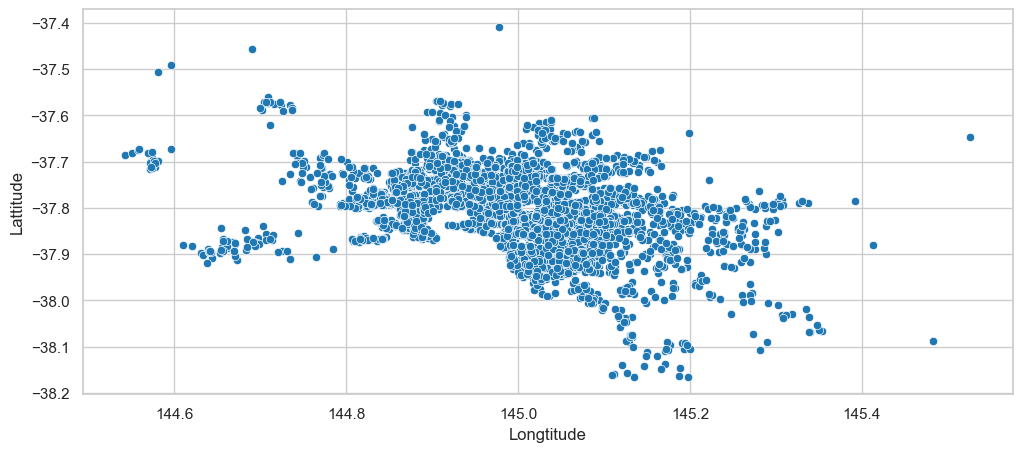

In [134]:
sns.scatterplot(
    data=train_set,
    x='Longtitude',
    y='Lattitude'
)

In [135]:
train_long_lat = train_set_extended[['Longtitude', 'Lattitude']]
valid_long_lat = valid_set_extended[['Longtitude', 'Lattitude']]
test_long_lat = test_set_extended[['Longtitude', 'Lattitude']]

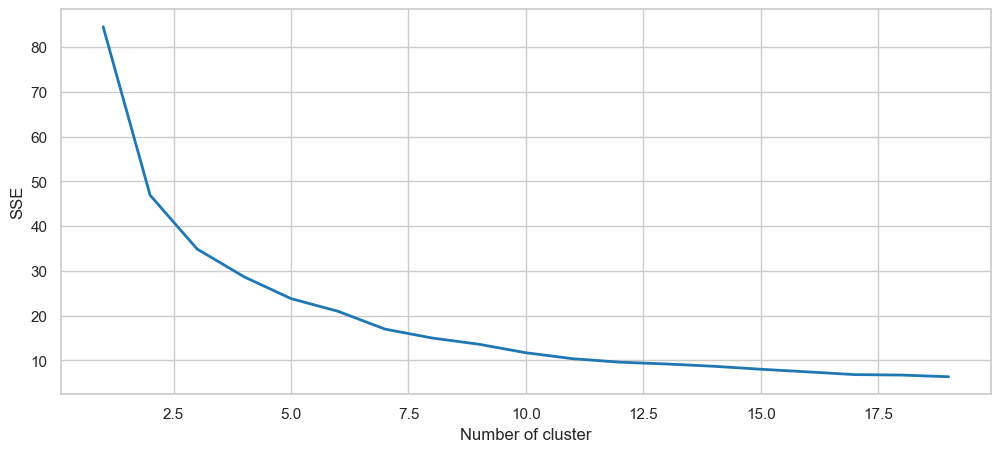

In [136]:
# Will watch which is the elbow

sse = {}
for k in range(1, 20):
    kmeans = KMeans(
        n_clusters=k, 
        max_iter=1000, 
        n_init='auto'
    ).fit(train_long_lat)
        
    # Squarred Sum of Errors
    sse[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [137]:
divisor = 12
n_features = math.floor((train_set['YearBuilt'].nunique() / divisor))

print('Number of features: ', n_features)
k_means = KMeans(
    n_clusters=n_features, 
    n_init='auto',
    max_iter=1000
)

k_means.fit(train_long_lat)

Number of features:  9


KMeans(max_iter=1000, n_clusters=9, n_init='auto')

In [138]:
# With the same model trained we predict both groups for test & trian
labels_train = k_means.labels_
labels_valid = k_means.predict(valid_long_lat)
labels_test = k_means.predict(test_long_lat)

In [139]:
centroides = k_means.cluster_centers_
etiquetas = k_means.labels_

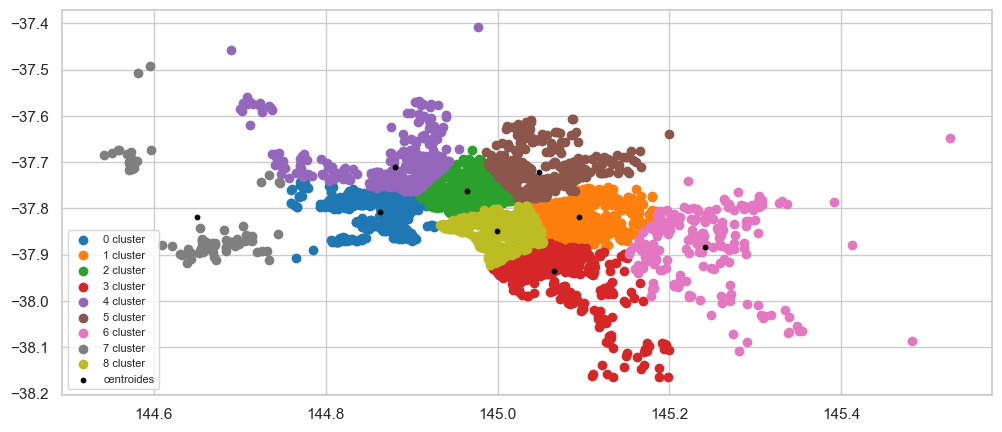

In [140]:
unique_labels = np.unique(labels_train)
 
for label in unique_labels:
    plt.scatter(
        train_long_lat.iloc[labels_train == label, 0], 
        train_long_lat.iloc[labels_train == label, 1], 
        label = f"{label} cluster",
    )

plt.scatter(
    centroides[:,0],
    centroides[:,1], 
    label='centroides', 
    color = 'k', 
    s=10
)

plt.legend(
    prop={'size': 8}
)
plt.show()

In [141]:
# Add this new feature into the dataframe
train_set_extended['location_group'] = labels_train
valid_set_extended['location_group'] = labels_valid
test_set_extended['location_group'] = labels_test

This location group might be very related to the council area, but we will try to use both and see which one works best.

## Ratios

We are going to create ratios that could be interesting features to the model.
- landsize/building_area
- bedrooms/building_area
- rooms/building_area
- car/building_area
- 

In [142]:
# Ratios and 
train_set_extended['bed_bath_ratio'] = train_set_extended['Bedroom2'] + 1 / train_set_extended['Bathroom'] + 1
train_set_extended['car_bed_ratio'] = train_set_extended['Car'] + 1/ train_set_extended['Bedroom2'] + 1
train_set_extended['bed_room_ratio'] = train_set_extended['Bedroom2'] + 1 / train_set_extended['Rooms'] + 1
train_set_extended['bath_room_ratio'] = train_set_extended['Bathroom'] + 1 / train_set_extended['Rooms'] + 1

train_set_extended['room_building_area_ratio'] = train_set_extended['Rooms'] + 1 / train_set_extended['BuildingArea'] + 1
train_set_extended['bed_building_area_ratio'] = train_set_extended['Bedroom2'] + 1 / train_set_extended['BuildingArea'] + 1
train_set_extended['bath_building_area_ratio'] = train_set_extended['Bathroom'] + 1 / train_set_extended['BuildingArea'] + 1


valid_set_extended['bed_bath_ratio'] = valid_set_extended['Bedroom2'] + 1 / valid_set_extended['Bathroom'] + 1
valid_set_extended['car_bed_ratio'] = valid_set_extended['Car'] + 1/ valid_set_extended['Bedroom2'] + 1
valid_set_extended['bed_room_ratio'] = valid_set_extended['Bedroom2'] + 1 / valid_set_extended['Rooms'] + 1
valid_set_extended['bath_room_ratio'] = valid_set_extended['Bathroom'] + 1 / valid_set_extended['Rooms'] + 1

valid_set_extended['room_building_area_ratio'] = valid_set_extended['Rooms'] + 1 / valid_set_extended['BuildingArea'] + 1
valid_set_extended['bed_building_area_ratio'] = valid_set_extended['Bedroom2'] + 1 / valid_set_extended['BuildingArea'] + 1
valid_set_extended['bath_building_area_ratio'] = valid_set_extended['Bathroom'] + 1 / valid_set_extended['BuildingArea'] + 1


test_set_extended['bed_bath_ratio'] = test_set_extended['Bedroom2'] + 1 / test_set_extended['Bathroom'] + 1
test_set_extended['car_bed_ratio'] = test_set_extended['Car'] + 1/ test_set_extended['Bedroom2'] + 1
test_set_extended['bed_room_ratio'] = test_set_extended['Bedroom2'] + 1 / test_set_extended['Rooms'] + 1
test_set_extended['bath_room_ratio'] = test_set_extended['Bathroom'] + 1 / test_set_extended['Rooms'] + 1

test_set_extended['room_building_area_ratio'] = test_set_extended['Rooms'] + 1 / test_set_extended['BuildingArea'] + 1
test_set_extended['bed_building_area_ratio'] = test_set_extended['Bedroom2'] + 1 / test_set_extended['BuildingArea'] + 1
test_set_extended['bath_building_area_ratio'] = test_set_extended['Bathroom'] + 1 / test_set_extended['BuildingArea'] + 1

In [143]:
ratio_features = ['bed_bath_ratio', 'car_bed_ratio', 'bed_room_ratio', 'bath_room_ratio', 'room_building_area_ratio', 'bed_building_area_ratio', 'bath_building_area_ratio']

## Logs

We will create also some logarithms of the columns:

In [144]:
train_set_extended['Distance_log'] = np.log(train_set_extended['Distance'])
train_set_extended['Landsize_log'] = np.log(train_set_extended['Landsize'])
train_set_extended['BuildingArea_log'] = np.log(train_set_extended['BuildingArea'])
train_set_extended['Propertycount_log'] = np.log(train_set_extended['Propertycount'])

valid_set_extended['Distance_log'] = np.log(valid_set_extended['Distance'])
valid_set_extended['Landsize_log'] = np.log(valid_set_extended['Landsize'])
valid_set_extended['BuildingArea_log'] = np.log(valid_set_extended['BuildingArea'])
valid_set_extended['Propertycount_log'] = np.log(valid_set_extended['Propertycount'])

test_set_extended['Distance_log'] = np.log(test_set_extended['Distance'])
test_set_extended['Landsize_log'] = np.log(test_set_extended['Landsize'])
test_set_extended['BuildingArea_log'] = np.log(test_set_extended['BuildingArea'])
test_set_extended['Propertycount_log'] = np.log(test_set_extended['Propertycount'])

In [145]:
log_features = ['Distance_log', 'BuildingArea_log', 'Landsize_log', 'Propertycount_log']

## Square

Same but making the exponential of the values.


In [146]:
train_set_extended['Distance_sqr'] = np.sqrt(train_set_extended['Distance'])
train_set_extended['Landsize_sqr'] = np.sqrt(train_set_extended['Landsize'])
train_set_extended['BuildingArea_sqr'] = np.sqrt(train_set_extended['BuildingArea'])
train_set_extended['Propertycount_sqr'] = np.sqrt(train_set_extended['Propertycount'])

valid_set_extended['Distance_sqr'] = np.sqrt(valid_set_extended['Distance'])
valid_set_extended['Landsize_sqr'] = np.sqrt(valid_set_extended['Landsize'])
valid_set_extended['BuildingArea_sqr'] = np.sqrt(valid_set_extended['BuildingArea'])
valid_set_extended['Propertycount_sqr'] = np.sqrt(valid_set_extended['Propertycount'])

test_set_extended['Distance_sqr'] = np.sqrt(test_set_extended['Distance'])
test_set_extended['Landsize_sqr'] = np.sqrt(test_set_extended['Landsize'])
test_set_extended['BuildingArea_sqr'] = np.sqrt(test_set_extended['BuildingArea'])
test_set_extended['Propertycount_sqr'] = np.sqrt(test_set_extended['Propertycount'])

In [147]:
sqr_features = ['Distance_sqr', 'Landsize_sqr', 'BuildingArea_sqr', 'Propertycount_sqr']

Finally, for all transformations, we make sure we do not have inf.

In [148]:
train_set_extended.replace([np.inf, -np.inf], 0, inplace=True)
valid_set_extended.replace([np.inf, -np.inf], 0, inplace=True)
test_set_extended.replace([np.inf, -np.inf], 0, inplace=True)

# Feature Selection 

TODO: Apply standard scaler (to price also divide by the mean in train?)
TODO: BuildingArea NANs not solved
Apply random forecast and then we select the most important features

And for example:
- seller_g: feature already taken into consideration
- date: ' 
- suburb: select most important suburbs? (rich, median, poor)
- region name: '

In [149]:
features_to_drop = [
    'Date',
    'Postcode',
    'Regionname',
    'Lattitude',
    'Longtitude',
    # 'YearBuilt',
    *pc_features_to_drop,
    *seller_features_to_drop,
    *suburb_features_to_drop,
    *council_features_to_drop,
    *region_features_to_drop,
    # *log_features, 
    *sqr_features,
    # Some date variables assume not necessary
    # 'day_of_week_sold',
    # 'day_of_month_sold',
    # 'day_of_year_sold',
    # 'week_of_month_sold',
    # 'is_month_start',
    # 'is_month_end',
    # 'is_quarter_start',   # quarter end can influence as reduce in the price to meet sells
    # 'is_year_start',
    # 'Resold',   # low amount
    # For the ones we have ratios
    # 'Rooms',
    # 'Bedroom2',
    # 'Bathroom',
    # 'Car'
]


train_set_selected = train_set_extended.drop(features_to_drop + ['Price_log'], axis=1)
valid_set_selected = valid_set_extended.drop(features_to_drop, axis=1)
test_set_selected = test_set_extended.drop(features_to_drop, axis=1)

In [150]:
# Better, we choose which ones do we want
features_to_keep = [
    'Distance_log',
    'Landsize_log',   # corr of 0.09 with the pricing
    'seller_class',
    'suburb_class',
    'northern_metropolitan',
    'western_metropolitan',
    'southern_metropolitan',
    'eastern_metropolitan',
    'other',
    'month_sold',
    'Method_S',  # TODO: convert as categorical
    'Method_SA',
    'Method_SP',
    'Method_VB',
    'Type_t',
    'Type_u',
    'location_group',
    'bed_bath_ratio',
    'car_bed_ratio',
    'bath_room_ratio',
    'room_building_area_ratio',
    'bed_building_area_ratio',
    'bath_building_area_ratio'
]

# train_set_selected = train_set_extended[features_to_keep + ['Price']]
# valid_set_selected = valid_set_extended[features_to_keep + ['Price']]
# test_set_selected = test_set_extended[features_to_keep]

In [151]:
# We handle also the dtypes
def convert_category(train_set_selected, valid_set_selected, test_set_selected):
    category_cols = [
        'seller_class',
        'suburb_class',
        'council_class',
        'northern_metropolitan',
        'western_metropolitan',
        'southern_metropolitan',
        'eastern_metropolitan',
        'other',
        'Resold',
        'location_group',
        'Method_S',
        'Method_SA',
        'Method_SP',
        'Method_VB',
        'Type_t',
        'Type_u'
    ]

    for col in category_cols:
        train_set_selected[col] = train_set_selected[col].astype('category')
        valid_set_selected[col] = valid_set_selected[col].astype('category')
        test_set_selected[col] = test_set_selected[col].astype('category')
    
    return train_set_selected, valid_set_selected, test_set_selected
    

train_set_selected, valid_set_selected, test_set_selected = convert_category(train_set_selected, valid_set_selected, test_set_selected)

In [152]:
def convert_int8(train_set_selected, valid_set_selected, test_set_selected):
    int8_cols = [
        'winter', 'spring', 'summer', 'fall'
    ]
    
    for col in int8_cols:
        train_set_selected[col] = train_set_selected[col].astype('int8')
        valid_set_selected[col] = valid_set_selected[col].astype('int8')
        test_set_selected[col] = test_set_selected[col].astype('int8')
    
    return train_set_selected, valid_set_selected, test_set_selected

train_set_selected, valid_set_selected, test_set_selected = convert_int8(train_set_selected, valid_set_selected, test_set_selected)

In [153]:
print(train_set_selected.dtypes.to_string())

Rooms                          int64
Price                        float64
Distance                     float64
Bedroom2                     float64
Bathroom                     float64
Car                          float64
Landsize                     float64
BuildingArea                 float64
YearBuilt                    float64
year_sold                      int32
prop_count_bkt                  int8
seller_class                category
suburb_class                category
council_class               category
northern_metropolitan       category
western_metropolitan        category
southern_metropolitan       category
eastern_metropolitan        category
other                       category
month_sold                      int8
quarter_sold                    int8
day_of_week_sold                int8
day_of_month_sold               int8
day_of_year_sold               int16
week_of_month_sold              int8
week_of_year_sold               int8
is_wknd                         int8
i

In [154]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']

train_set_selected_num = train_set_selected.select_dtypes(include=numerics).drop(['Price'], axis=1)
train_set_selected_num.head(3)

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,year_sold,prop_count_bkt,month_sold,quarter_sold,day_of_week_sold,day_of_month_sold,day_of_year_sold,week_of_month_sold,week_of_year_sold,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,winter,spring,summer,fall,diff_built_sold,bed_bath_ratio,car_bed_ratio,bed_room_ratio,bath_room_ratio,room_building_area_ratio,bed_building_area_ratio,bath_building_area_ratio,Distance_log,Landsize_log,BuildingArea_log,Propertycount_log
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3320,3,12.1,3.0,1.0,0.0,559.0,134.425061,1974.0,2017,6,6,2,6,17,168,3,24,1,0,0,0,0,0,0,1,1,0,1,43.0,5.0,1.333333,4.333333,2.333333,4.007439,4.007439,2.007439,2.493205,6.326149,4.901007,9.227689
1185,2,4.2,2.0,1.0,0.0,62.0,86.074133,1997.0,2016,3,11,4,6,19,324,3,46,1,0,0,0,0,0,0,1,1,1,0,19.0,4.0,1.500000,3.500000,2.500000,3.011618,3.011618,2.011618,1.435085,4.127134,4.455209,8.568456
5059,3,7.5,3.0,2.0,0.0,276.0,149.000000,1910.0,2017,6,3,1,1,6,65,1,10,0,0,0,0,0,0,0,1,0,1,1,107.0,4.5,1.333333,4.333333,3.333333,4.006711,4.006711,3.006711,2.014903,5.620401,5.003946,9.133891


In [155]:
X_train_set_selected = train_set_selected.drop(['Price'], axis=1)
Y_train_set_selected = train_set_selected.Price

In [156]:
X_train_set_selected.describe()

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,year_sold,prop_count_bkt,month_sold,quarter_sold,day_of_week_sold,day_of_month_sold,day_of_year_sold,week_of_month_sold,week_of_year_sold,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,winter,spring,summer,fall,diff_built_sold,bed_bath_ratio,car_bed_ratio,bed_room_ratio,bath_room_ratio,room_building_area_ratio,bed_building_area_ratio,bath_building_area_ratio,Distance_log,Landsize_log,BuildingArea_log,Propertycount_log
count,4668.000000,4668.000000,4668.000000,4668.000000,4668.0,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.0,4668.0,4668.0,4668.0,4668.0,4668.0,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000,4668.000000
mean,2.910668,10.348158,2.893102,1.500428,0.0,508.505990,141.538905,1965.768066,2016.534919,3.962511,6.728792,2.564053,4.980506,16.609254,190.270780,2.833548,27.194302,0.734147,0.0,0.0,0.0,0.0,0.0,0.0,0.903599,0.689803,0.612682,0.793916,50.766852,4.656271,1.390728,4.283867,2.891193,3.921023,3.903457,2.510784,2.174180,6.051449,4.821389,8.721139
std,0.930145,5.964195,0.972920,0.665505,0.0,301.530323,129.713976,35.202259,0.498833,2.564716,2.726150,0.932228,1.915575,7.971495,83.466111,1.176666,11.844782,0.441833,0.0,0.0,0.0,0.0,0.0,0.0,0.295172,0.462624,0.487189,0.404535,35.160665,0.893971,0.181194,0.842575,0.612582,0.927446,0.970297,0.664271,0.598383,0.647971,0.519398,0.654409
min,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,1856.000000,2016.000000,0.000000,1.000000,1.000000,1.000000,2.000000,7.000000,1.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,1.250000,1.250000,2.004831,1.004975,1.006864,-0.356675,0.000000,0.000000,5.963579
25%,2.000000,6.300000,2.000000,1.000000,0.0,283.750000,88.000000,1950.000000,2016.000000,2.000000,5.000000,2.000000,4.000000,9.000000,135.000000,2.000000,19.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,1.000000,18.000000,4.000000,1.333333,3.500000,2.333333,3.011905,3.011854,2.008850,1.840550,5.648092,4.477337,8.346879
50%,3.000000,9.400000,3.000000,1.000000,0.0,504.430593,127.000810,1970.000000,2017.000000,4.000000,7.000000,3.000000,6.000000,16.000000,196.000000,3.000000,28.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,47.000000,4.500000,1.333333,4.333333,2.500000,4.007331,4.007131,2.014493,2.240710,6.223430,4.844193,8.786151
75%,3.000000,13.100000,3.000000,2.000000,0.0,664.000000,159.181500,1998.000000,2017.000000,6.000000,9.000000,3.000000,6.000000,24.000000,252.000000,4.000000,36.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,67.000000,5.000000,1.500000,4.333333,3.333333,4.011111,4.010101,3.006289,2.572612,6.498282,5.070045,9.242904
max,8.000000,47.400000,20.000000,8.000000,0.0,3634.000000,6791.000000,2018.000000,2017.000000,8.000000,12.000000,4.000000,7.000000,30.000000,346.000000,5.000000,49.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,160.000000,22.000000,2.000000,21.333333,9.250000,9.005263,21.002886,9.003571,3.858622,8.198089,8.823353,9.982761


In [166]:
scaler = StandardScaler()

X_train_set_selected[train_set_selected_num.columns.values] = scaler.fit_transform(X_train_set_selected[train_set_selected_num.columns.values])

In [196]:
model = RandomForestRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)


space = {
    'n_estimators': [100, 200, 300, 400], # np.arange(100, 1000, 100),
    'max_depth': [3, 5],
    'min_samples_leaf': [8, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': np.arange(3, 6, 1),
    # 'boostrap': [True, False]
}

model_rf = RandomizedSearchCV(
    estimator=model, 
    param_distributions=space, 
    scoring='neg_mean_squared_error',
    n_iter=30,
    n_jobs=-1,
    cv=cv,
    random_state=0,
    verbose=10
)

In [197]:
model_rf.fit(X_train_set_selected, Y_train_set_selected)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=3, random_state=0),
                   estimator=RandomForestRegressor(), n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5],
                                        'max_features': array([3, 4, 5]),
                                        'min_samples_leaf': [8, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=0, scoring='neg_mean_squared_error',
                   verbose=10)

In [222]:
np.sqrt(-model_rf.best_score_)

304235.05410321394

[CV 4/4; 2/30] START max_depth=3, max_features=11, min_samples_leaf=10, min_samples_split=5, n_estimators=100
[CV 4/4; 2/30] END max_depth=3, max_features=11, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=-102488698087.019 total time=   0.8s
[CV 2/4; 3/30] START max_depth=10, max_features=7, min_samples_leaf=10, min_samples_split=10, n_estimators=1000
[CV 2/4; 3/30] END max_depth=10, max_features=7, min_samples_leaf=10, min_samples_split=10, n_estimators=1000;, score=-66863067723.116 total time=  10.3s
[CV 1/4; 9/30] START max_depth=10, max_features=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300
[CV 1/4; 9/30] END max_depth=10, max_features=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300;, score=-59674660922.811 total time=   3.3s
[CV 1/4; 10/30] START max_depth=3, max_features=6, min_samples_leaf=3, min_samples_split=5, n_estimators=500
[CV 1/4; 10/30] END max_depth=3, max_features=6, min_samples_leaf=3, min_samples_split=5, n_estimators

[CV 3/4; 1/30] START max_depth=10, max_features=11, min_samples_leaf=10, min_samples_split=10, n_estimators=100
[CV 3/4; 1/30] END max_depth=10, max_features=11, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=-60720477484.566 total time=   1.5s
[CV 2/4; 4/30] START max_depth=5, max_features=11, min_samples_leaf=10, min_samples_split=10, n_estimators=100
[CV 2/4; 4/30] END max_depth=5, max_features=11, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=-82621676819.983 total time=   1.0s
[CV 1/4; 5/30] START max_depth=5, max_features=6, min_samples_leaf=3, min_samples_split=10, n_estimators=300
[CV 1/4; 5/30] END max_depth=5, max_features=6, min_samples_leaf=3, min_samples_split=10, n_estimators=300;, score=-89710342625.423 total time=   2.1s
[CV 2/4; 6/30] START max_depth=3, max_features=7, min_samples_leaf=10, min_samples_split=10, n_estimators=500
[CV 2/4; 6/30] END max_depth=3, max_features=7, min_samples_leaf=10, min_samples_split=10, n_estimat

[CV 2/4; 2/30] START max_depth=3, max_features=11, min_samples_leaf=10, min_samples_split=5, n_estimators=100
[CV 2/4; 2/30] END max_depth=3, max_features=11, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=-108017920352.384 total time=   0.8s
[CV 3/4; 3/30] START max_depth=10, max_features=7, min_samples_leaf=10, min_samples_split=10, n_estimators=1000
[CV 3/4; 3/30] END max_depth=10, max_features=7, min_samples_leaf=10, min_samples_split=10, n_estimators=1000;, score=-65676271885.935 total time=  10.5s
[CV 4/4; 9/30] START max_depth=10, max_features=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300
[CV 4/4; 9/30] END max_depth=10, max_features=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300;, score=-62886484653.522 total time=   3.4s
[CV 4/4; 10/30] START max_depth=3, max_features=6, min_samples_leaf=3, min_samples_split=5, n_estimators=500
[CV 4/4; 10/30] END max_depth=3, max_features=6, min_samples_leaf=3, min_samples_split=5, n_estimators

[CV 3/4; 2/30] START max_depth=3, max_features=11, min_samples_leaf=10, min_samples_split=5, n_estimators=100
[CV 3/4; 2/30] END max_depth=3, max_features=11, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=-103840224586.773 total time=   0.7s
[CV 4/4; 3/30] START max_depth=10, max_features=7, min_samples_leaf=10, min_samples_split=10, n_estimators=1000
[CV 4/4; 3/30] END max_depth=10, max_features=7, min_samples_leaf=10, min_samples_split=10, n_estimators=1000;, score=-66694997809.513 total time=  10.4s
[CV 3/4; 9/30] START max_depth=10, max_features=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300
[CV 3/4; 9/30] END max_depth=10, max_features=7, min_samples_leaf=3, min_samples_split=5, n_estimators=300;, score=-61927561897.790 total time=   3.2s
[CV 2/4; 10/30] START max_depth=3, max_features=6, min_samples_leaf=3, min_samples_split=5, n_estimators=500
[CV 2/4; 10/30] END max_depth=3, max_features=6, min_samples_leaf=3, min_samples_split=5, n_estimators

[CV 1/4; 1/30] START max_depth=10, max_features=11, min_samples_leaf=10, min_samples_split=10, n_estimators=100
[CV 1/4; 1/30] END max_depth=10, max_features=11, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=-59098047494.540 total time=   1.5s
[CV 3/4; 4/30] START max_depth=5, max_features=11, min_samples_leaf=10, min_samples_split=10, n_estimators=100
[CV 3/4; 4/30] END max_depth=5, max_features=11, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=-81156963113.562 total time=   1.0s
[CV 3/4; 5/30] START max_depth=5, max_features=6, min_samples_leaf=3, min_samples_split=10, n_estimators=300
[CV 3/4; 5/30] END max_depth=5, max_features=6, min_samples_leaf=3, min_samples_split=10, n_estimators=300;, score=-87365978004.375 total time=   2.1s
[CV 3/4; 6/30] START max_depth=3, max_features=7, min_samples_leaf=10, min_samples_split=10, n_estimators=500
[CV 3/4; 6/30] END max_depth=3, max_features=7, min_samples_leaf=10, min_samples_split=10, n_estimat

In [212]:
model = RandomForestRegressor(**model_rf.best_params_)

In [213]:
model.fit(X_train_set_selected, Y_train_set_selected)

RandomForestRegressor(max_depth=5, max_features=5, min_samples_leaf=8,
                      min_samples_split=10)

####  Feature importances

<BarContainer object of 56 artists>

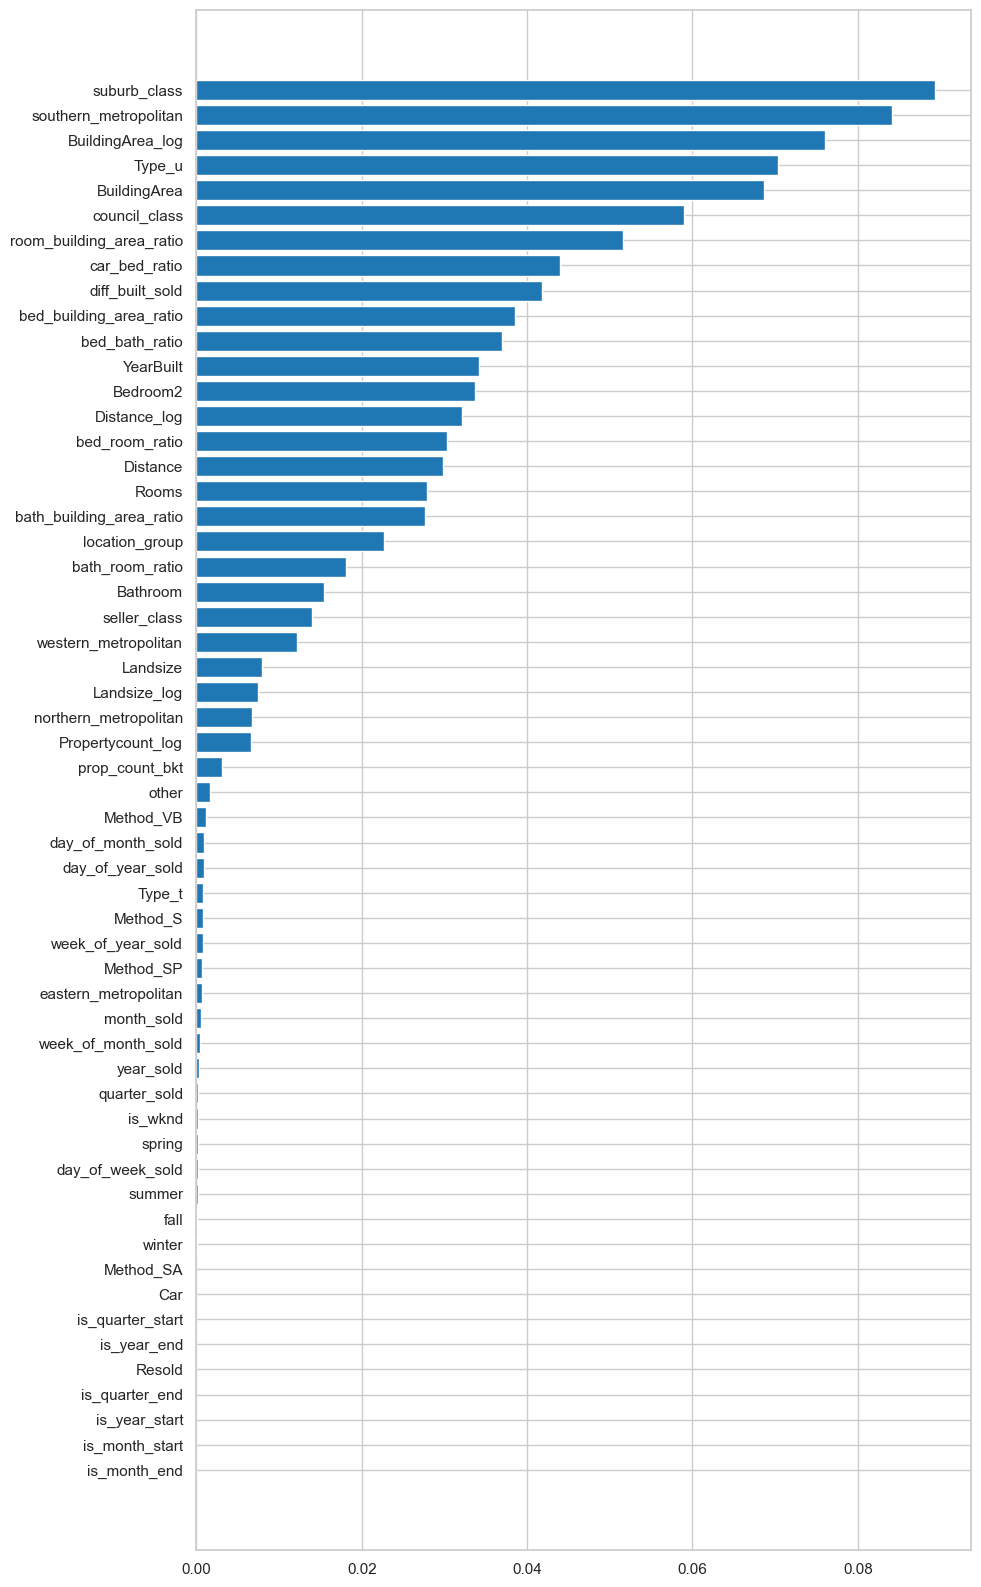

In [228]:
fig, ax = plt.subplots(figsize=(10, 20))
sorted_idx = model.feature_importances_.argsort()
ax.barh(model.feature_names_in_[sorted_idx], model.feature_importances_[sorted_idx])

### Create the final model

TODO: Try out xgboost as well  --> adding more regularization

In [214]:
X_valid_set_selected = valid_set_selected.drop(['Price'], axis=1)
Y_valid_set_selected = valid_set_selected.Price

X_valid_set_selected[train_set_selected_num.columns.values] = scaler.transform(X_valid_set_selected[train_set_selected_num.columns.values])

In [215]:
X_train_cols_order = X_train_set_selected.columns.values

In [216]:
valid_set_predicted = model.predict(X_valid_set_selected[X_train_cols_order])

In [217]:
from sklearn.metrics import mean_squared_error
mean_squared_error(valid_set_predicted, Y_valid_set_selected, squared=False)

618674.6831355504

In [ ]:
# TODO: Feature importances

# Model Creation

In some we do cross-validation, and in others train/val split.

## K-Neighbor Regressor

#### Council Area Features

In [ ]:
n_neighbors = 2
X = train_set_extended[[*council_features, 'YearBuilt', 'Propertycount', 'BuildingArea', 'Bedroom2']]
X.fillna(0.0, inplace=True)
Y = train_set['Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

model = KNeighborsRegressor(n_neighbors)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print(mean_squared_error(Y_test, y_pred, squared=False))
r2_score(Y_test, y_pred)

#### Location Group

In [ ]:
n_neighbors = 2
X = train_set_extended[['location_group', 'YearBuilt', 'Propertycount', 'BuildingArea', 'Bedroom2']]
X.fillna(0.0, inplace=True)
Y = train_set['Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

model = KNeighborsRegressor(n_neighbors)
model.fit(X_train, Y_train)

In [ ]:
y_pred = model.predict(X_test)

print(mean_squared_error(Y_test, y_pred, squared=False))
r2_score(Y_test, y_pred)

## Linear Regression

## Decision Trees

In [ ]:
train_set_extended.head(3)

In [ ]:
def get_all_features():
    all_features = [
        'location_group', 
        'YearBuilt', 
        'Propertycount', 
        'Rooms',
        'Landsize', 
        'BuildingArea',
        'Distance',
        'Bedroom2', 
        'Bathroom',
        'Car', 
    ]

    all_features = all_features + postcode_features   # not providing good results, as we do not have historical info
    all_features = all_features + seller_features
    all_features = all_features + log_features
    all_features = all_features + sqr_features
    all_features = all_features + method_features[:-1]  # multicollinearity: we exclude one variable
    all_features = all_features + type_features[:-1]
    all_features = all_features + council_features[:-1]  
    all_features = all_features + date_features
    
    return all_features

In [ ]:
all_features = get_all_features()
all_features